In [20]:
from __future__ import division
import os 

import datetime
import json
import gzip
import numpy as np
import re
import pandas as pd
import seaborn as sns

from collections import defaultdict, OrderedDict
from ethiopian_date import ethiopian_date
from matplotlib.colors import LogNorm
from sklearn.linear_model import BayesianRidge

# Plotting code
from plot_util import *

%pylab inline
pylab.rcParams['figure.figsize'] = (12.0, 8.0) # set size of figures"
plt.rcParams.update({'font.size': 24})

Populating the interactive namespace from numpy and matplotlib


<h1> Functions </h1>

In [8]:
#LAST_YEAR_REGION_POP = dataframe.groupby(['E_year', 'Region'])['pop'].mean().groupby(level=1).last()
#LAST_YEAR_REGION_POP_WEIGHT = LAST_YEAR_REGION_POP / LAST_YEAR_REGION_POP.sum()

def plot_nation_rmse(tests, target, end_date, savedir=None):
    rmse_data = {}
    for i in range(1, len(tests)):
        pred_text = 'prediction_m_%s' % (i*6)
        DF_testing = pd.concat(tests[i], ignore_index=True)
        DF_testing = DF_testing[DF_testing['E_Date'] < end_date]

        # Sum over all the regions that make up the national indicator. After the sum, groupby by level 0.
        nation_rmse = DF_testing.groupby(['Indicator', 'Real_Date']).sum()\
            .groupby(level=0).apply(lambda x: np.sqrt((((x[target] - x[pred_text]) / x[target])**2).mean()))

        fig=figure()
        fig.set_size_inches(8, 6)

        nation_rmse.index = ['\n'.join(val.split('malaria')[-1].split(':')) for val in nation_rmse.index]
        nation_rmse.plot.bar(color='b', alpha=0.6, fontsize=24)
        plt.title(pred_text)

        if savedir:
            plt.tight_layout()
            plt.savefig('%s/Nation_RMSE_m%s.png' % (savedir, (i*6)))

        rmse_data.update({'nation_rmse_m%s' % (i*6): nation_rmse})

    return rmse_data

def plot_region_rmse(tests, target, end_date, savedir=None):
    ''' Loop through all of the tests.
    Make plots for RMSE and RMSE normalized to the fraction of total population.
    Return the RMSE for each testing period.'''
    rmse_data = {}
    for i in range(1, len(tests)):
        save_postfix = ''
        pred_text = 'prediction_m_%s' % (i*6)
        DF_testing = pd.concat(tests[i], ignore_index=True)
        DF_testing = DF_testing[DF_testing['E_Date'] < end_date]
        
        # Sum over all the regions that make up the national indicator... after the sum, groupby by level 0.
        region_rmse = DF_testing.replace(0,1).groupby(['Region', 'Indicator'])\
            .apply(lambda x: np.sqrt((((x[target] - x[pred_text]) / x[target])**2).mean()))

        # Make two plots. One with only RMSE and the other normalized to region population.
        for j in range(2):
            fig=figure()
            fig.set_size_inches(10, 8)
        
            if j == 1:
                # Normalize to population.
                population = DF_testing.groupby(['Region', 'Indicator'])['pop'].mean()
                pop_fraction = population / DF_testing.groupby(['Region'])['pop'].mean().sum()
                region_rmse = region_rmse * pop_fraction
                save_postfix = 'normed'

            result = region_rmse.reset_index().pivot(index='Region', columns='Indicator', values=0).replace(np.nan,0)
            result.columns=['\n'.join(val.split('malaria')[-1].split(':')) for val in result.columns]

            sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})
            sns.heatmap(result, annot=True, fmt=".2f", cmap='viridis', label='big',\
                        square=False,linewidths=0.1, cbar=False, norm=LogNorm(vmin=result.min(), vmax=result.max()))
            plt.title(pred_text)
            
            if savedir:
                plt.tight_layout()
                plt.savefig('%s/Region_RMSE%s_m%s.png' % (savedir, save_postfix, (i*6)))
            
            # Only save when the region_rmse value is not normalized
            if j == 0:
                rmse_data.update({'region_rmse_m%s' % (i*6): region_rmse})
    
    return rmse_data

def plot_feature_imp(features, feature_imp, ylog=False):
    figure()
    sorted_index = sorted(range(len(feature_imp)),key=lambda x:feature_imp[x], reverse=True)
    xx = range(len(feature_imp))
    plt.bar(xx, feature_imp[sorted_index])
    xticks(xx, [features[i] for i in sorted_index], rotation = 'vertical')
    ylabel('Feature Importance')
    if ylog:
        yscale('log')
        
def generate_shifts(columns, months=1, width=3):
    name_maps = {}
    for column in columns:
        for i, j in enumerate(range(months, 2*months + width)):
            original_name = column if i==0 else '%s_shift_%s' % (column, i)
            new_name = '%s_shift_%s' % (column, j)
            name_maps.update({original_name: new_name})
    return name_maps

def add_rmse(dataframe, region_rmse):
    # To Do: Modify which RMSE to use, set to 12 months
    # Using the rmse calculated from model 12 months ago
    rmse_df = pd.DataFrame(region_rmse['region_rmse_m12']).reset_index().rename(columns= {0: 'rmse'})
    return dataframe.merge(rmse_df, how='left', on=['Region', 'Indicator'])

def check_neg(predictions):
    return np.array([int(pred) if pred >= 0 else 1 for pred in predictions])

def return_rmse(dataframe, pred_name, indicator, date_min, date_type):
    ''' Return RMSE of a region or weighted average for the Nation'''
    if dataframe.reset_index()['Region'].nunique() == 1:
        return dataframe.loc[(dataframe['Indicator'] == indicator) \
                & (dataframe['E_Date'] > date_min)].reset_index()['rmse'].mean()
    else:
        return dataframe.loc[(dataframe['Indicator'] == indicator) \
                & (dataframe['E_Date'] > date_min)].reset_index().groupby(['Region'])\
                ['weighted_rmse'].mean().sum()
        
def return_rmse_forecast(dataframe, indicator, date_min, date_type):
    ''' Return RMSE of a region or weighted average for the Nation'''
    cut = (dataframe['Indicator'] == indicator) & (dataframe['E_Date'] > date_min)
    if dataframe.reset_index()['Region'].nunique() == 1:
        return dataframe.loc[cut]\
            .reset_index().groupby(['E_Date'])['rmse'].mean()
    else:
        return dataframe.loc[(dataframe['Indicator'] == indicators[0]) & (dataframe['E_Date'] > end_date)]\
            .reset_index().groupby(['E_Date', 'Region'])['weighted_rmse'].mean().groupby(level=0).sum()


# Sigma
def return_sigma(dataframe, pred_name, indicator, date_min, date_type):
    ''' Return RMSE of a region or weighted average for the Nation'''
    cut = (dataframe['Indicator'] == indicator) & (dataframe['E_Date'] > date_min)
    if dataframe.reset_index()['Region'].nunique() == 1:
        return dataframe.loc[cut].reset_index().groupby('Region')\
            .apply(lambda x: (x[pred_name] * x['rmse']).mean())[0]
    else:
        # Add sigmas of each region in quaderature
        sigmas = dataframe.loc[cut].reset_index().groupby('Region')\
            .apply(lambda x: (x[pred_name] * x['rmse']).mean())
        return np.sqrt(np.sum(sigmas**2))
    
def return_sigma_forecast(dataframe, indicator, date_min, date_type):
    ''' Return RMSE of a region or weighted average for the Nation'''
    cut = (dataframe['Indicator'] == indicator) & (dataframe['E_Date'] > date_min)
    if dataframe.reset_index()['Region'].nunique() == 1:
        return dataframe.loc[cut].reset_index().groupby(['E_Date'])\
            .apply(lambda x: x['prediction'] * x['rmse']).values
    else:
        return dataframe.loc[cut].reset_index().groupby(['E_Date', 'Region'])\
            .apply(lambda x: x['prediction'] * x['rmse']).groupby(level=0)\
            .apply(lambda x: np.sqrt(np.sum(x**2))).values

<h1> Functions to run forecasts </h1>

In [3]:
def load_data(filepath = 'Malaria_regional_4-27-2017.csv'):
    DF_ind = pd.read_csv(filepath, index_col=0).reset_index(drop=True)

    # Convert string to datetime
    DF_ind['Real_Date'] = pd.to_datetime(DF_ind['Real_Date'])
    DF_ind['E_Date'] = pd.to_datetime(DF_ind['E_Date'])
    # list of indicator names
    indicators = DF_ind['Indicator'].unique()
    regions = DF_ind['Region'].unique()
    return DF_ind, indicators, regions

def setup_prediction_interval(dataframe, months=1):
    cols_to_shift = ['val', 'log_val', 'sg_val', 'log_sg_val', 'infection_rate', 'Region', 'Indicator']
    for i in range(1, 3 + months):
        suffixes = ('', '_shift_%s' % i)
        dataframe = dataframe.merge(dataframe[cols_to_shift].shift(i), left_index=True, right_index=True, how='left', suffixes=suffixes)

    return dataframe[(dataframe['Region'] == dataframe['Region_shift_%s' % i]) & \
                    (dataframe['Indicator'] == dataframe['Indicator_shift_%s' % i])]

In [4]:
# Constants 
EMONTH_LIST = ['is_emonth_%s' % i for i in range(1, 13)]
GENDER_AGE_INFO = ['is_male_child', 'is_female_child', 'is_male_teen', 'is_female_teen', 'is_male_adult']
REGION_INFO = ['net_frac', 'pop', 'minElevation_m', 'Elevation_m', 'Area_km2', 'density']
PRED_SHIFTS = range(0, 13, 6)

def zenprophet(DF_shift, MODEL, end_date, months=1, width=3):
    val_max = months + width
    w_max = months + width
    val_range = range(months, val_max)
    w_range = range(months, w_max)
    
    # Setup historical values to add to the dataframe
    precip_list = ['precipitation_shift_%s' % i for i in w_range]
    days_precip_list = ['days_precipitation_shift_%s' % i for i in w_range]
    wind_list = ['wind_avg_shift_%s' % i for i in w_range]
    temp_list = ['temp_min_shift_%s' % i for i in w_range]
    temp_list = ['temp_max_shift_%s' % i for i in w_range]
    humid_list = ['humid_avg_shift_%s' % i for i in w_range]
    solar_list = ['solar_shift_%s' % i for i in w_range]
    val_list = ['sg_val_shift_%s' % i for i in val_range]
    infec_rate_list = ['infection_rate_shift_%s' % i for i in val_range]

    features = EMONTH_LIST + REGION_LIST +  precip_list + wind_list + temp_list + humid_list \
                    + solar_list + val_list + infec_rate_list + REGION_INFO + GENDER_AGE_INFO

    trains = defaultdict(list)
    tests = defaultdict(list)
    shifts = []
    preds = []

    for region_group in REGION_GROUPS:
        region_cut = [region in region_group for region in DF_shift['Region']]
        DF_shift_region = DF_shift[region_cut].copy()
        DF_shift_region_cut = DF_shift[region_cut].copy()

        for i, offset in enumerate(PRED_SHIFTS):
            DF_training = DF_shift_region_cut[DF_shift_region_cut['E_Date'] < \
                        end_date - pd.offsets.relativedelta(months=offset)]
            DF_testing = DF_shift_region_cut.drop(DF_training.index)

            poststr = ''
            if offset != 0:
                poststr = '_m_%s' % offset
            prediction_str = 'prediction%s' % poststr

            # Training:
            y = DF_training[TARGET].values
            xtrain = DF_training[features].values
            MODEL.fit(xtrain, y)
            # TODO(attila) normalize coefficients and plot feature importances.
            #plot_feature_imp(features, MODEL.coef_)

            DF_training[prediction_str] = check_neg(MODEL.predict(xtrain))
            trains[i].append(DF_training)

            # Testing:
            xtest = DF_testing[features].values
            DF_testing[prediction_str] = check_neg(MODEL.predict(xtest))
            tests[i].append(DF_testing)

            #Make predictions one month forward
            x_all = DF_shift_region[features].values
            DF_shift_region[prediction_str] = check_neg(MODEL.predict(x_all))

            if i==0:
                preds.append(make_prediction(DF_shift_region, MODEL, end_date, features, months))
            
        shifts.append(DF_shift_region)
        
    DF_shift_all = pd.concat(shifts, ignore_index=True)
    preds_all = pd.concat(preds, ignore_index=True)
    #Tack on RMSE, from model trained 12 months ago and save figure.
    savedir = 'Bayes_tests_malaria_m_%s' % months
    region_rmse = plot_region_rmse(tests, TARGET, end_date, savedir=savedir)
    nation_rmse = plot_nation_rmse(tests, TARGET, end_date, savedir=savedir)
    return add_rmse(DF_shift_all, region_rmse), add_rmse(preds_all, region_rmse)

In [5]:
def make_prediction(DF_shift, MODEL, end_date, features, months):
    things_to_shift = ['val'] + list({feature.split('_shift')[0] for feature in features if '_shift' in feature})

    last_rows = DF_shift[DF_shift['E_Date'] == end_date].reset_index()
    last_rows.rename(columns=generate_shifts(things_to_shift, months), inplace=True)
    last_rows['E_Date'] = last_rows['E_Date'].apply(lambda x: x + pd.offsets.relativedelta(months=months))
    # replace Real_Date with incremented E_Date 
    last_rows['Real_Date'] = [ethiopian_date.EthiopianDateConverter.date_to_gregorian(date) for date in last_rows['E_Date']]
    last_rows['Real_Date'] = pd.to_datetime(last_rows['Real_Date'])
    last_rows['E_year'] = [val.year for val in last_rows['E_Date']]
    last_rows['E_month'] = [val.month for val in last_rows['E_Date']]
    last_rows['month'] = [val.year for val in last_rows['Real_Date']]
    last_rows['year'] = [val.year for val in last_rows['Real_Date']]
    # Update onehot month
    cur_emonth = last_rows['E_month'].max()
    for onehot_month in EMONTH_LIST:
        if int(onehot_month.split('_')[-1]) == cur_emonth:
            last_rows[onehot_month] = 1
        else:
            last_rows[onehot_month] = 0
    # Make predictions:
    x_forecast = last_rows[features].values
    last_rows['prediction'] = check_neg(MODEL.predict(x_forecast))
    return last_rows

<h1> Main </h1>

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


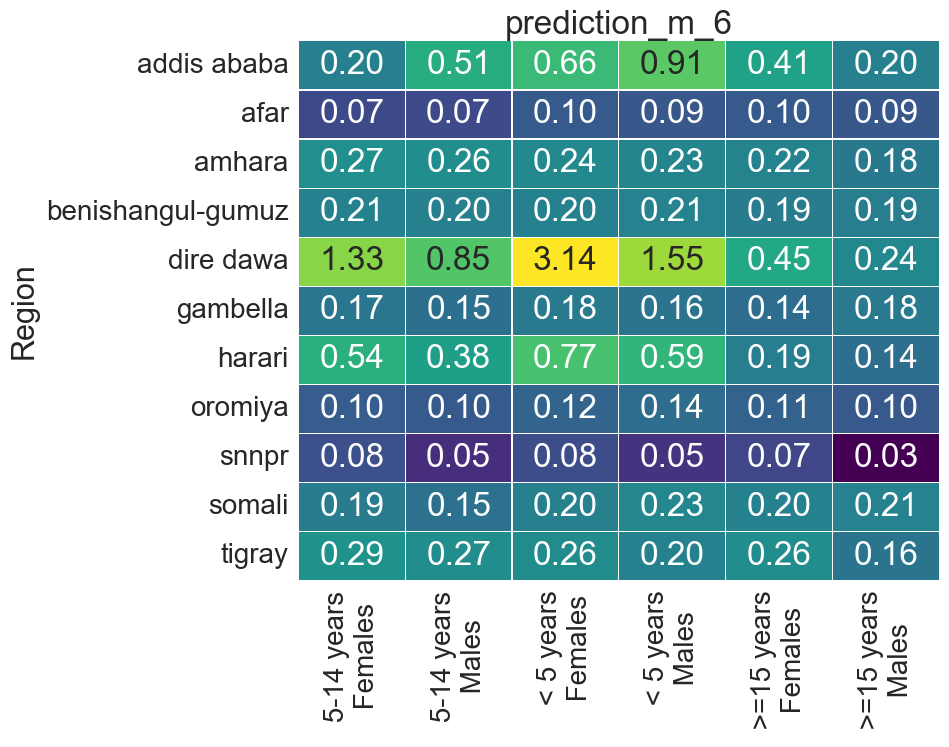

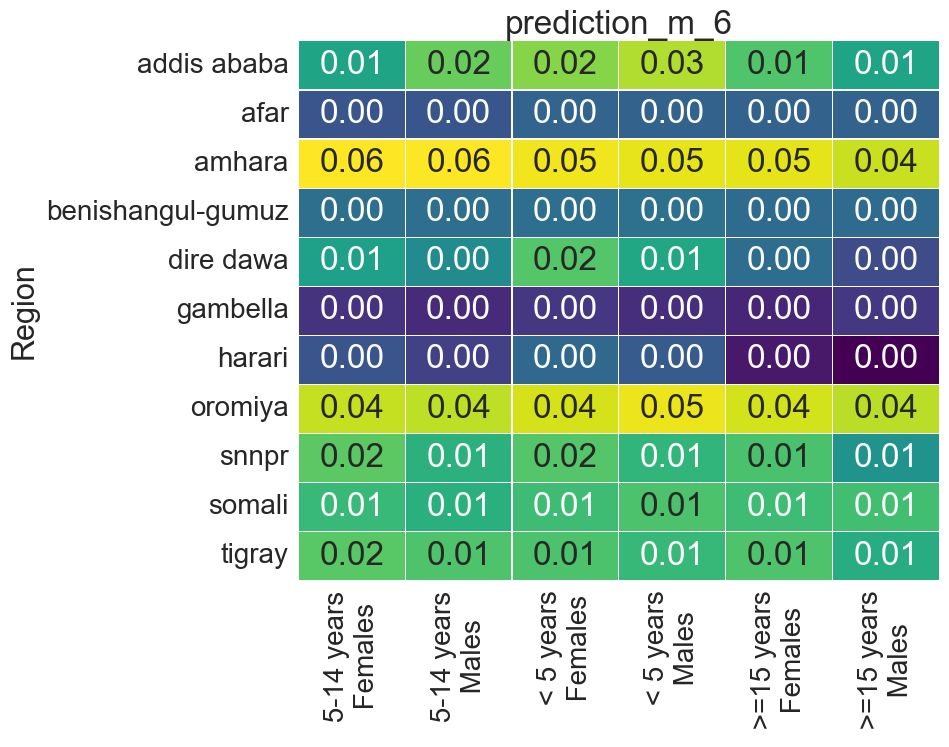

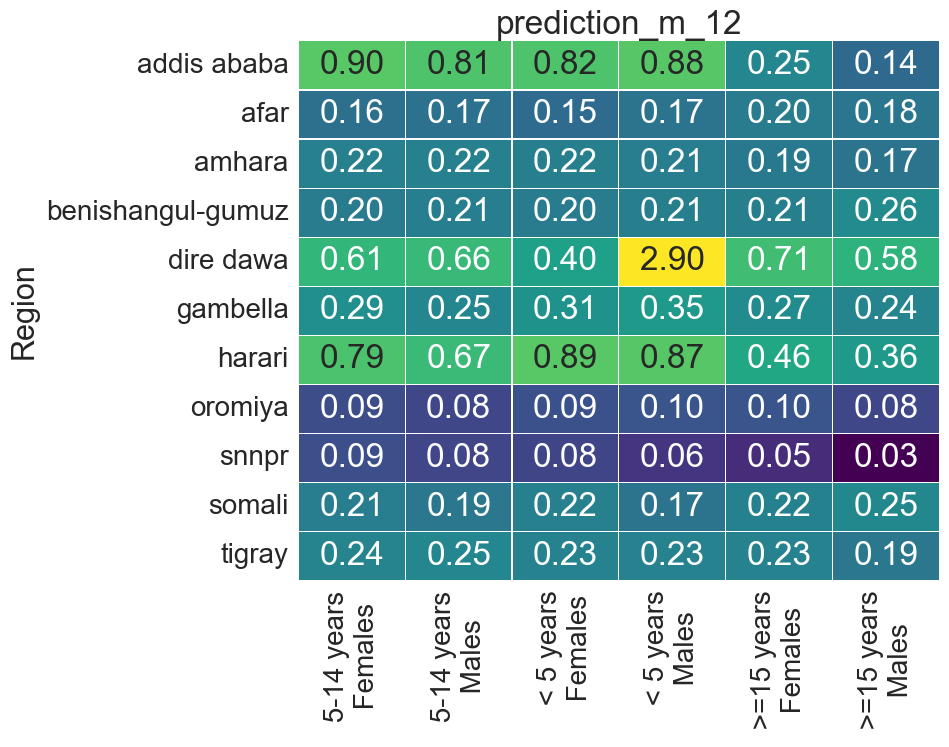

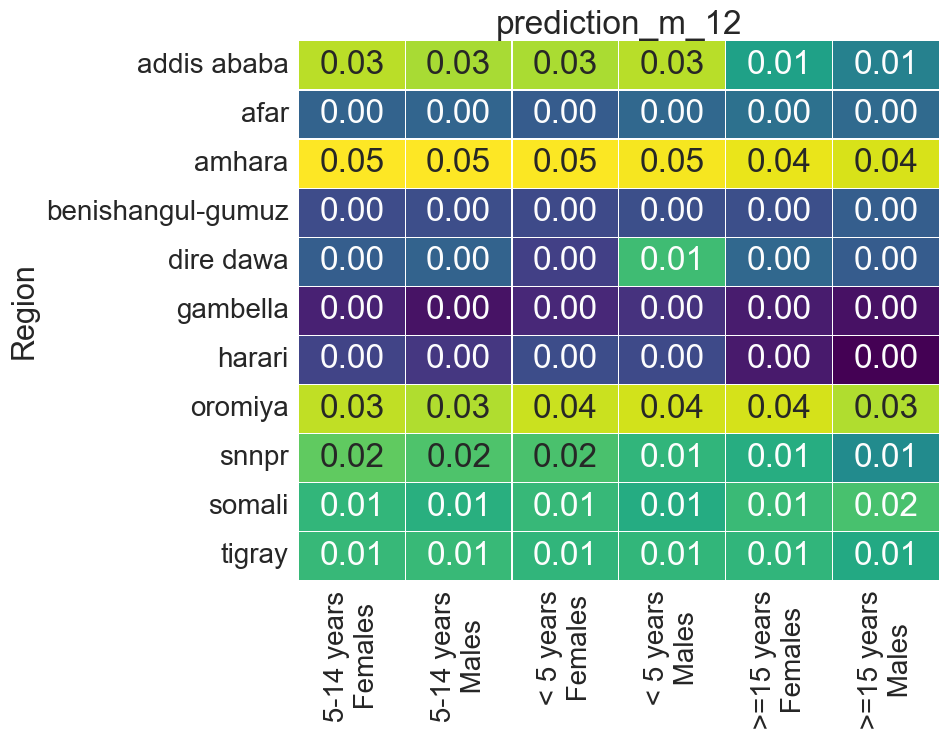

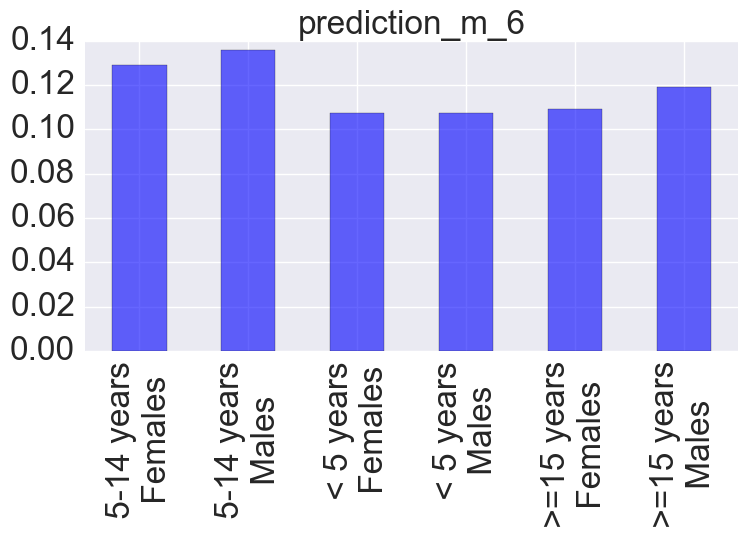

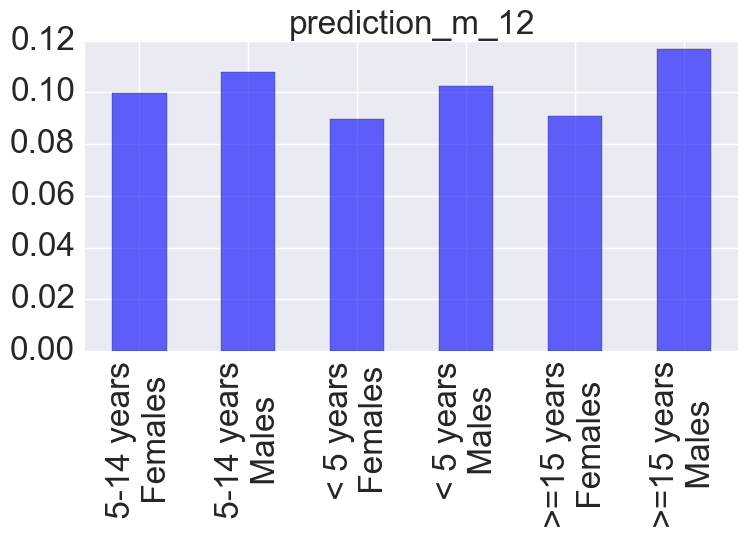

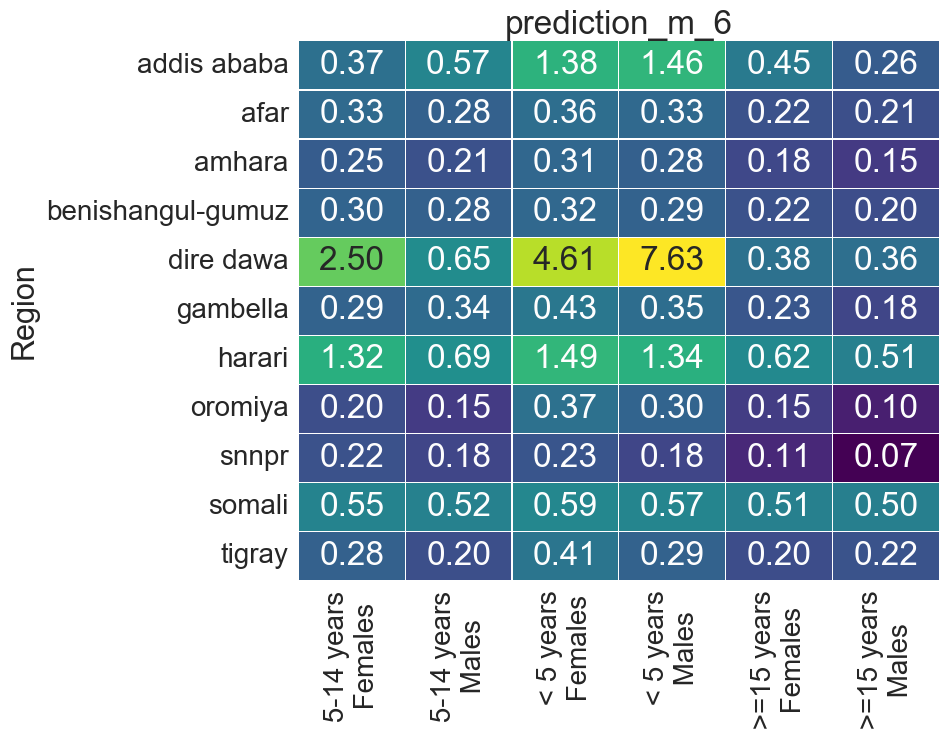

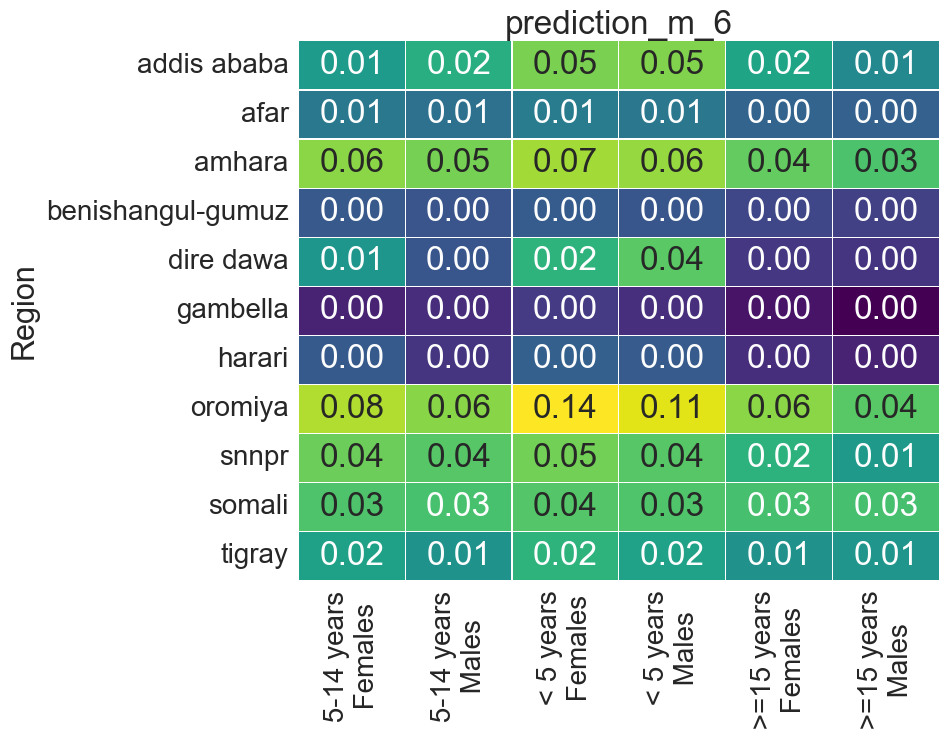

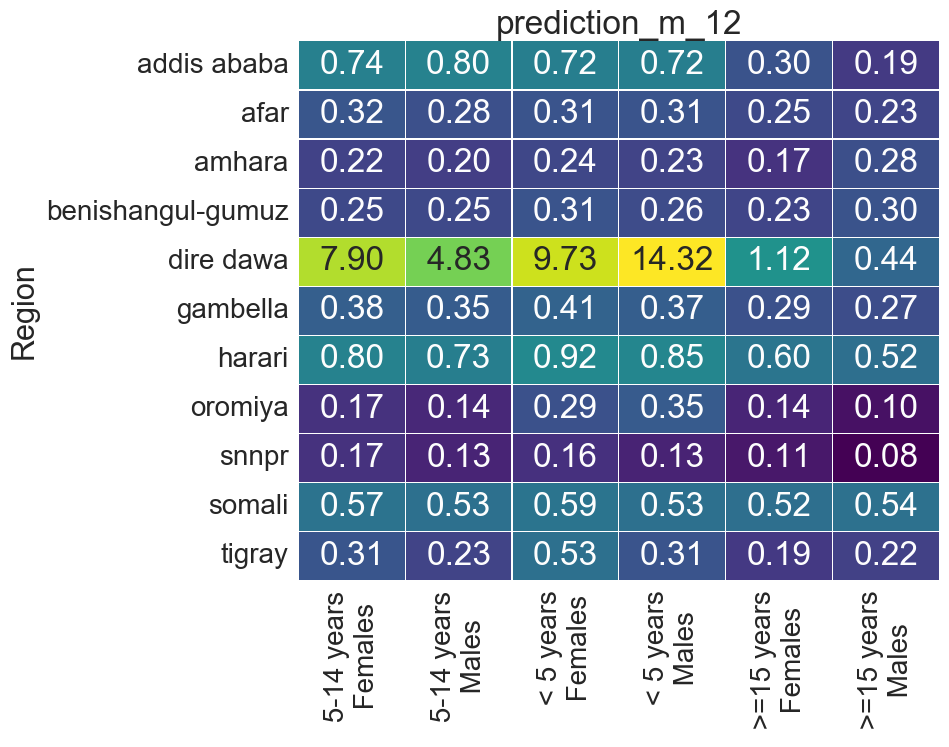

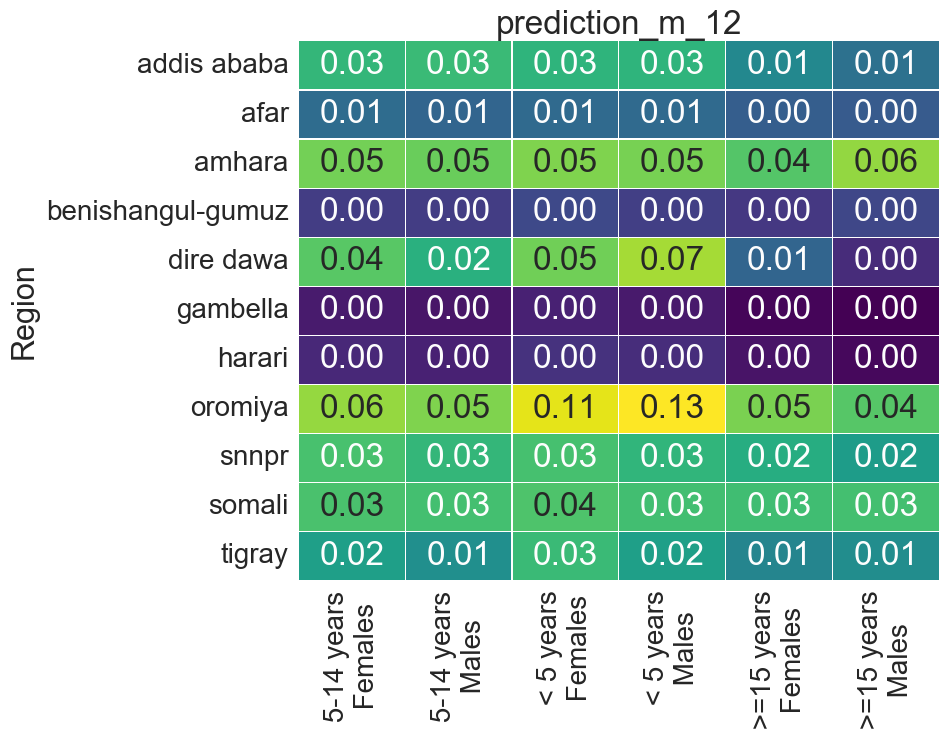

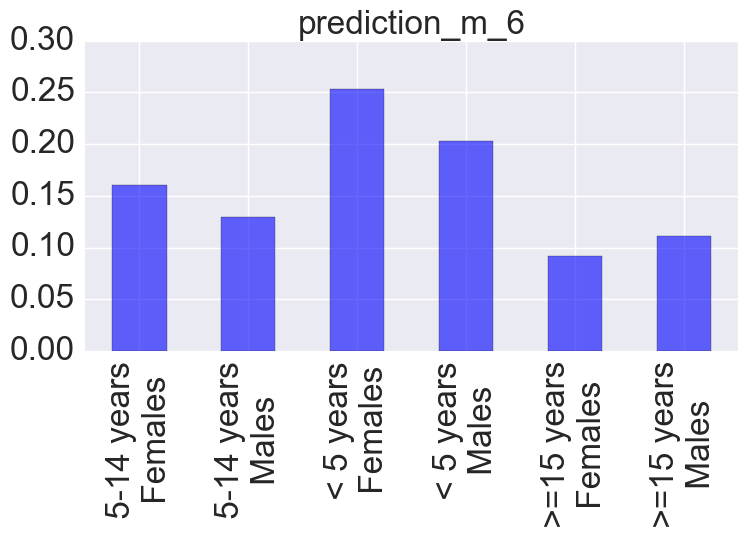

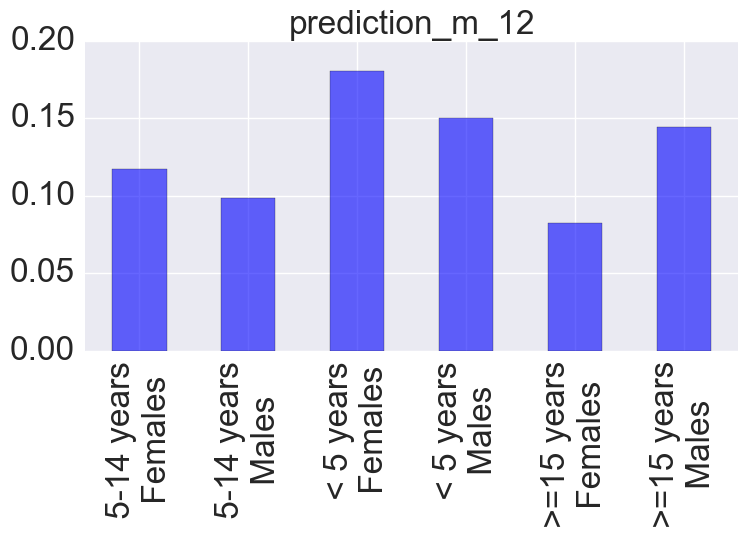

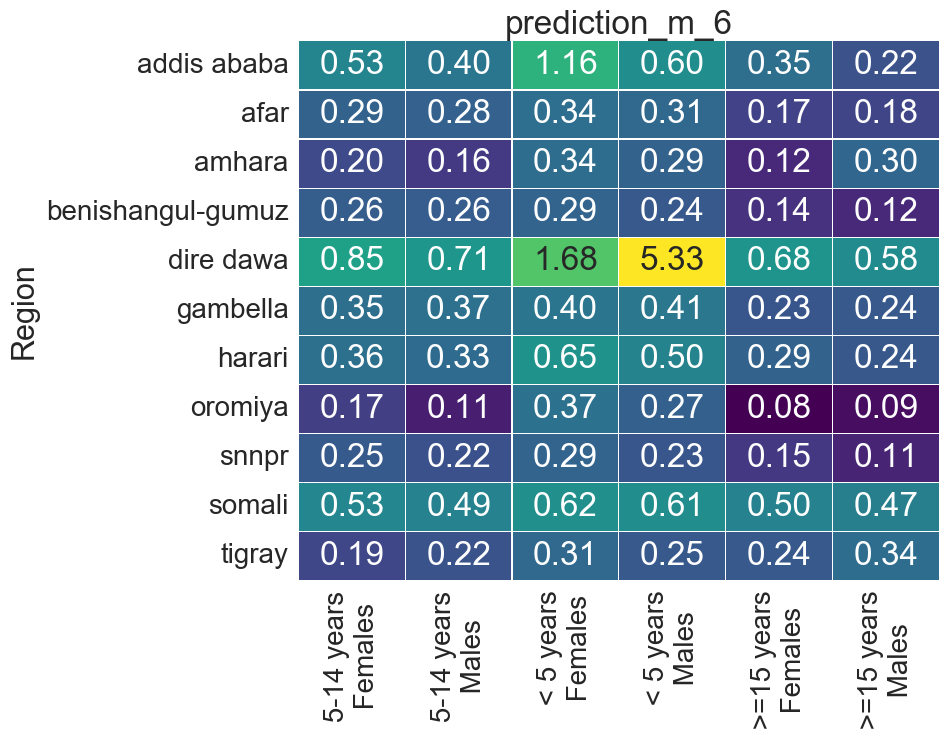

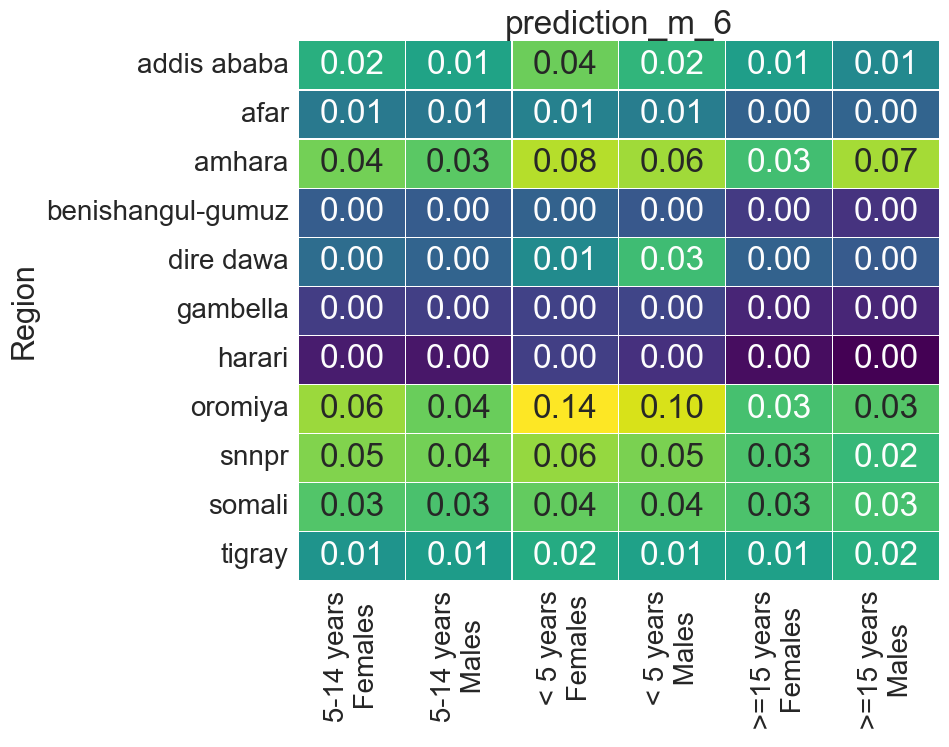

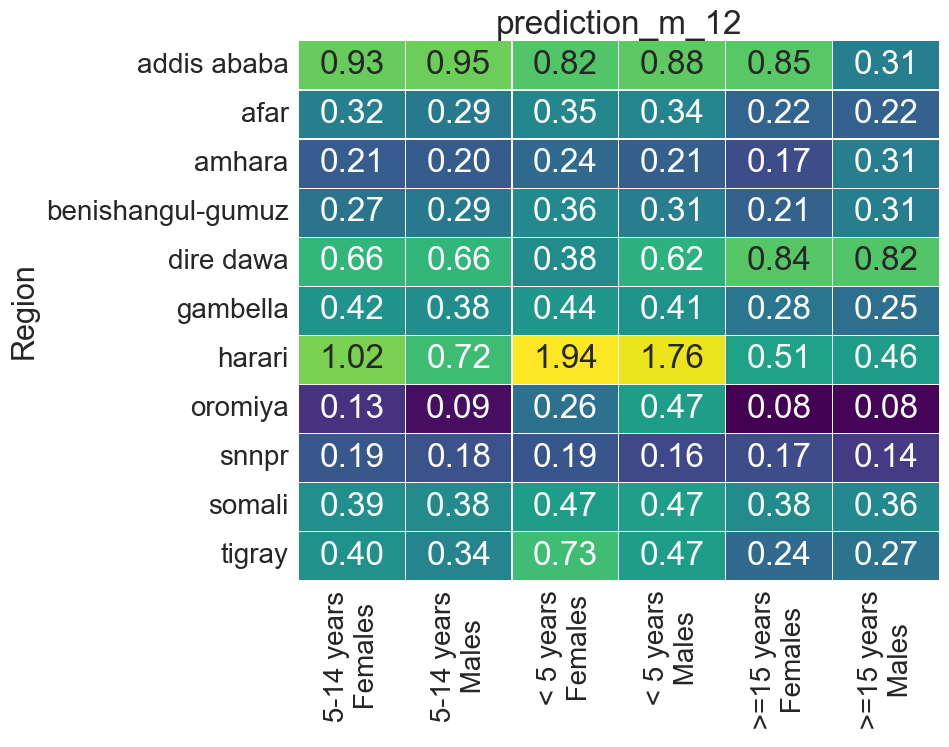

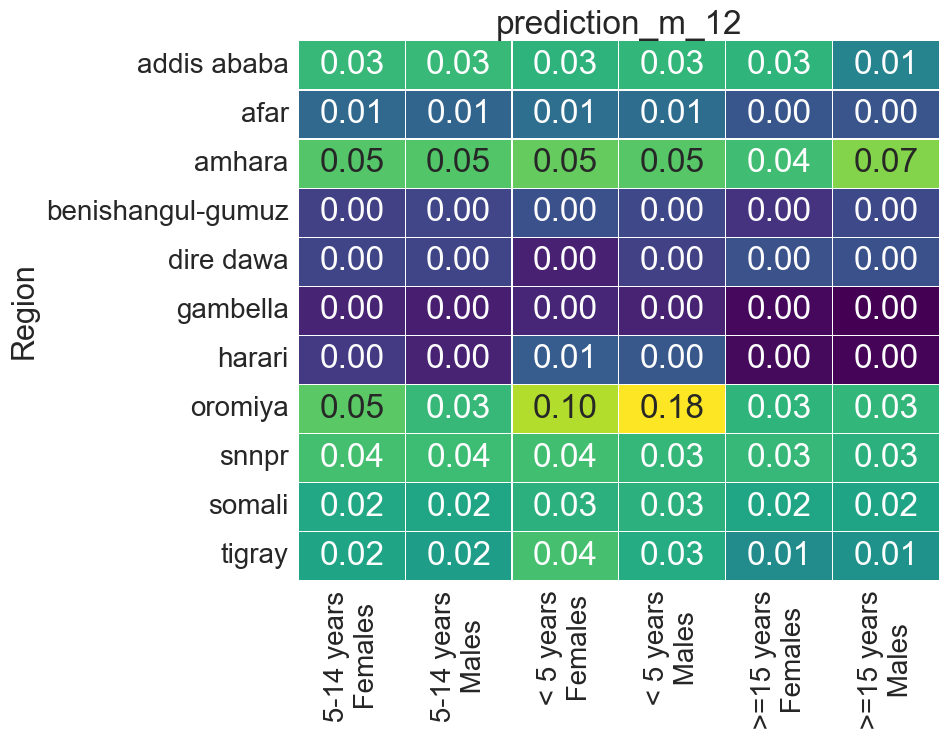

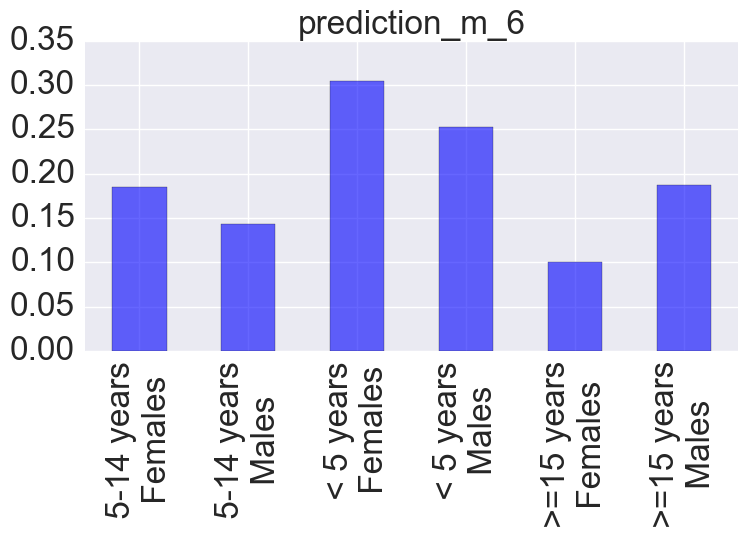

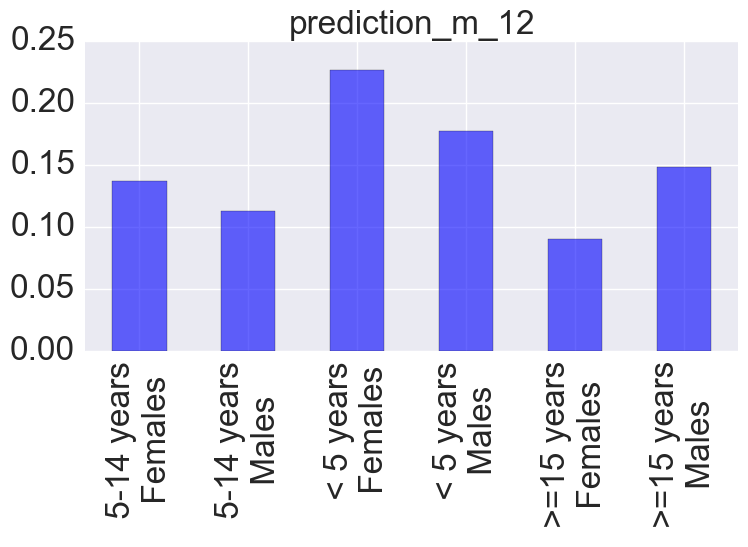

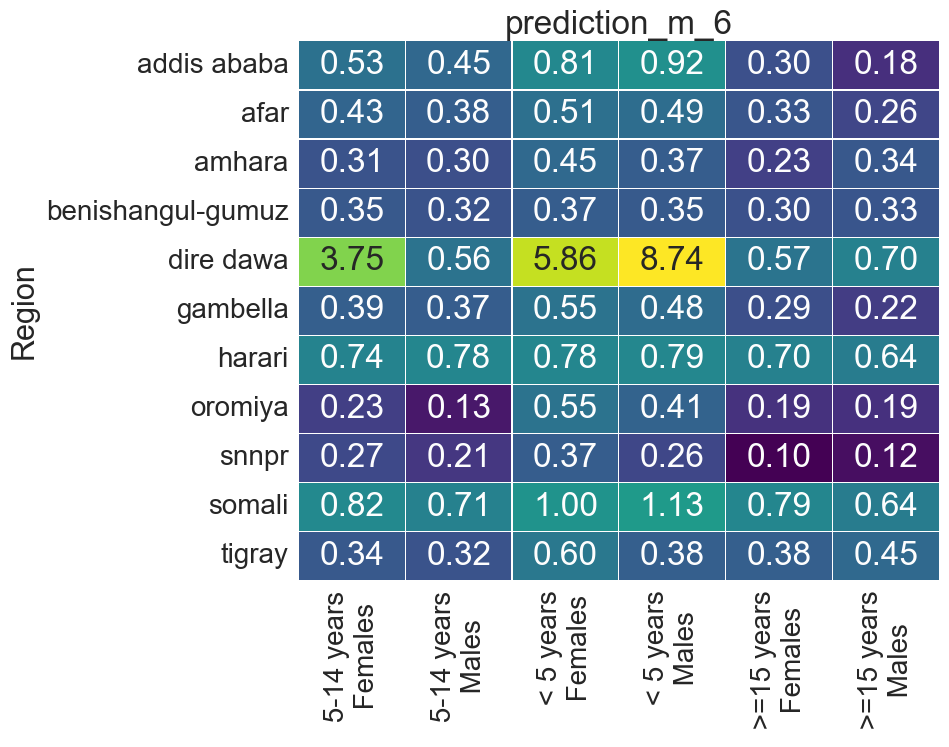

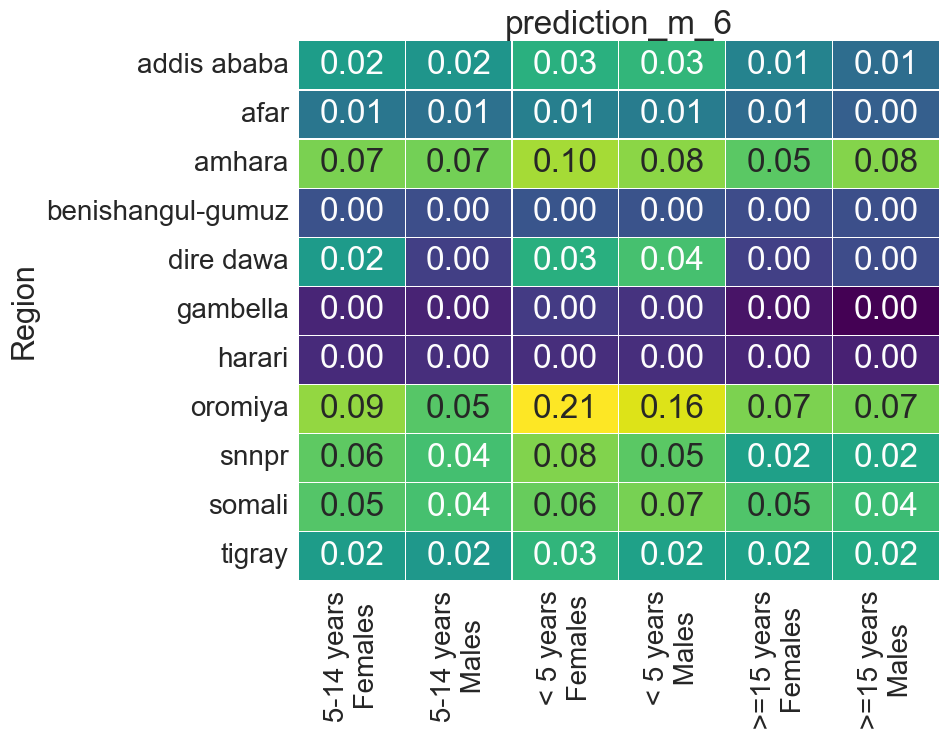

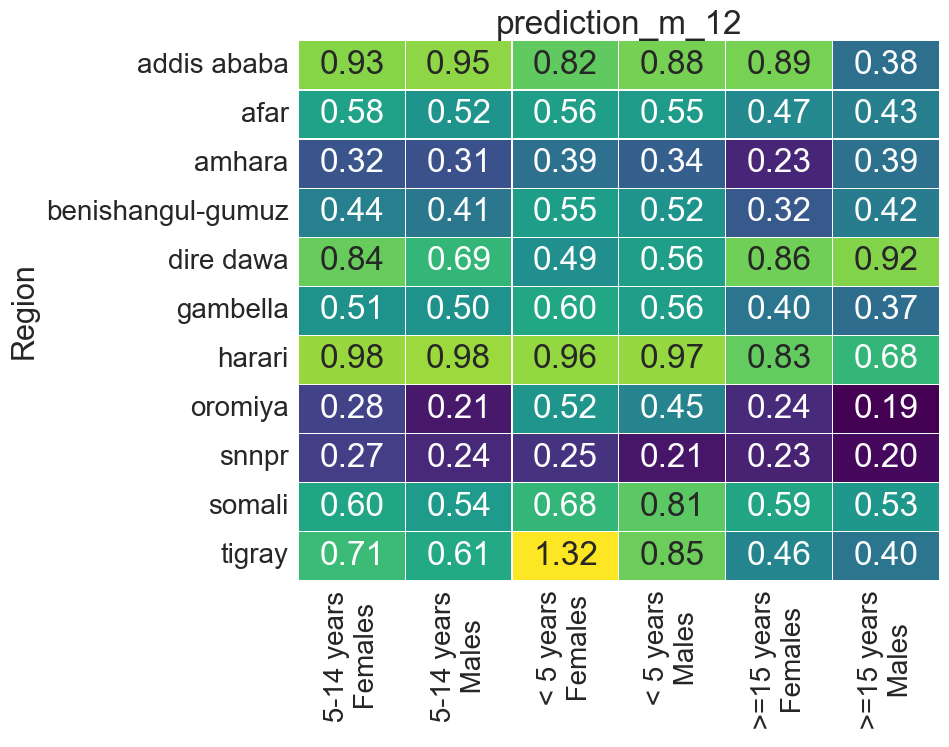

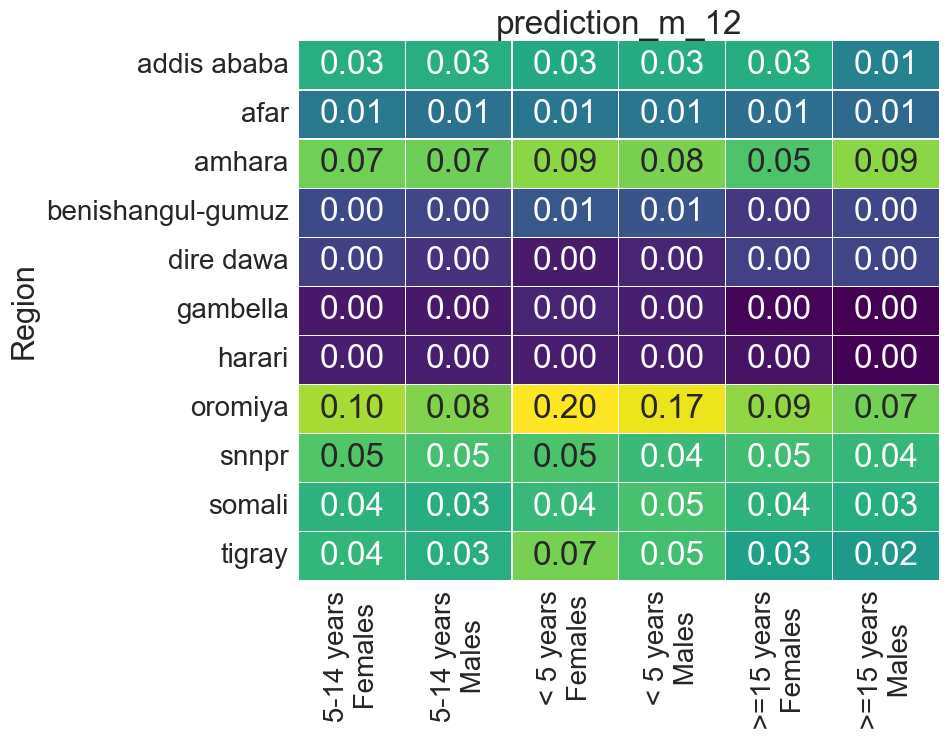

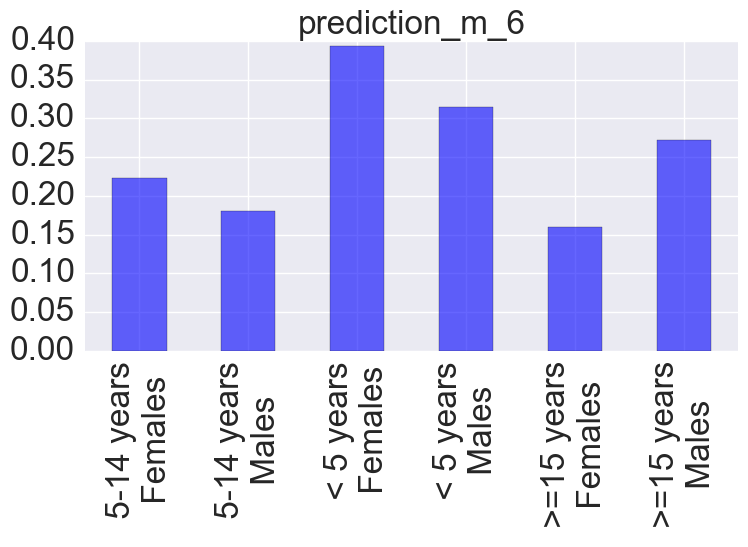

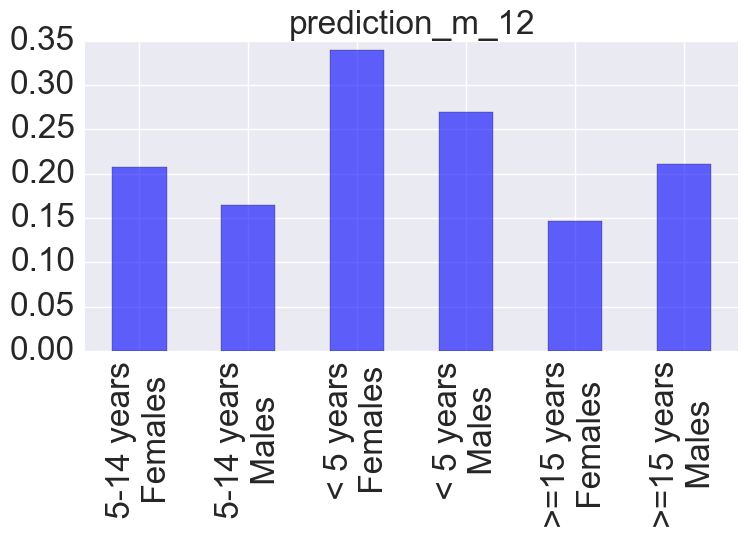

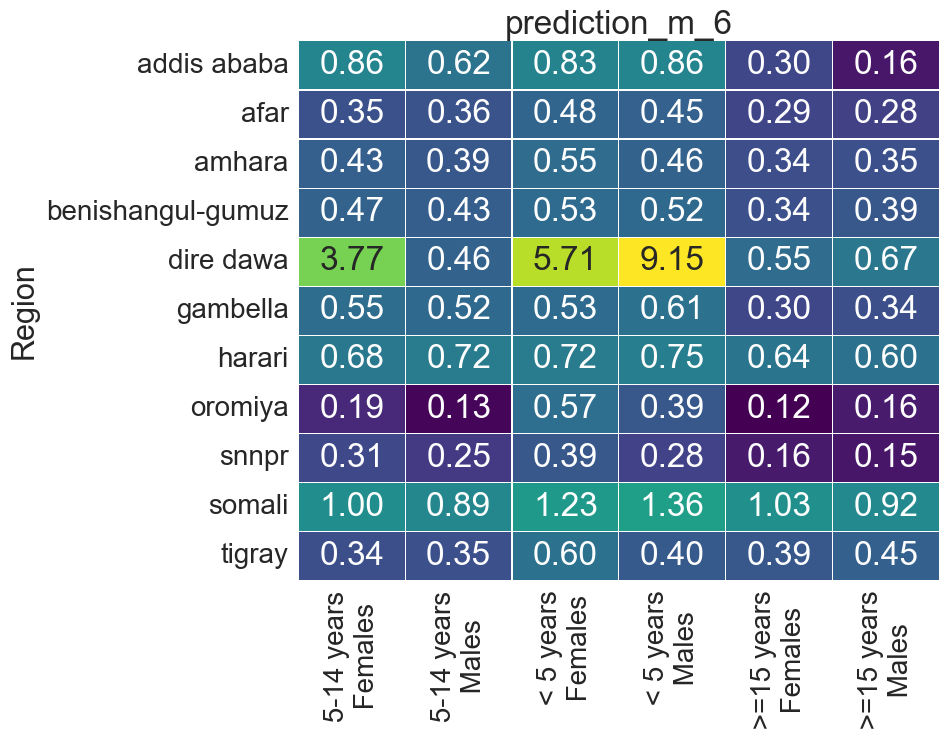

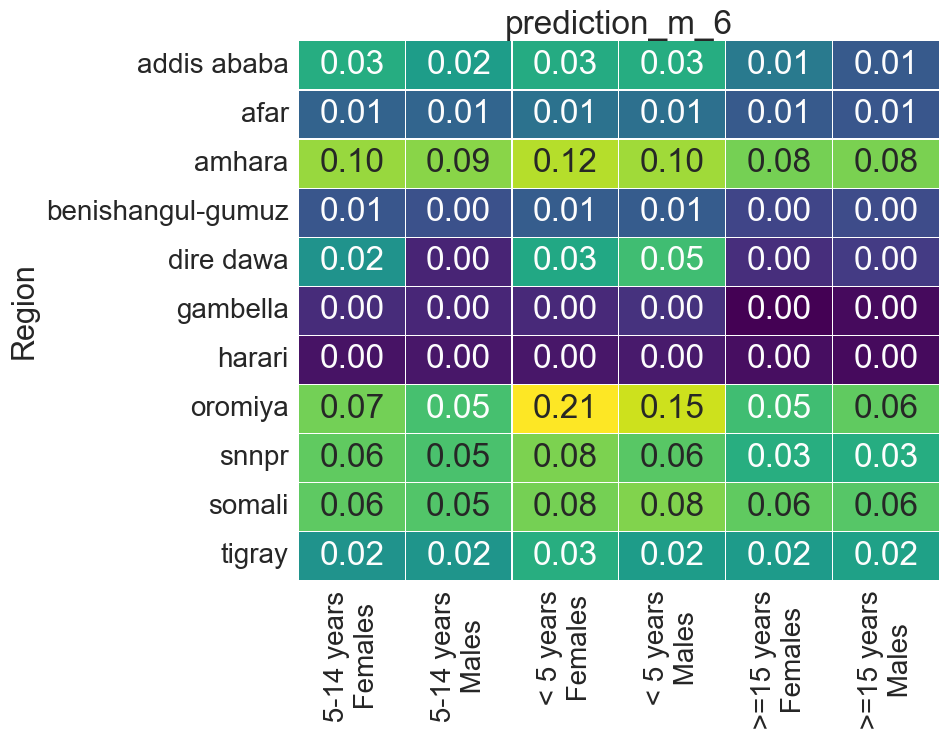

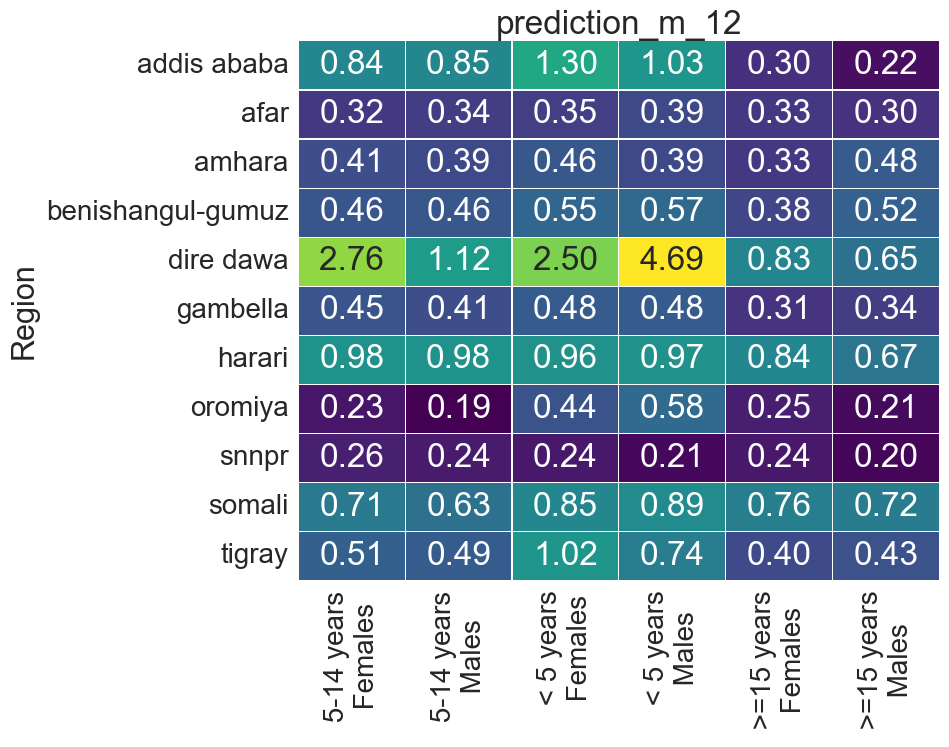

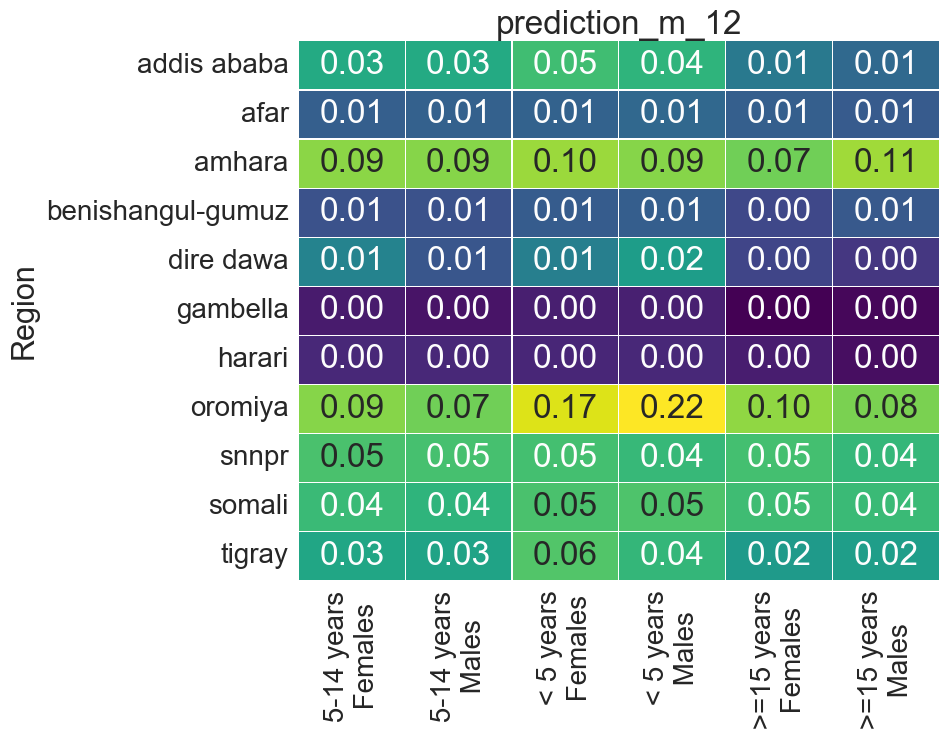

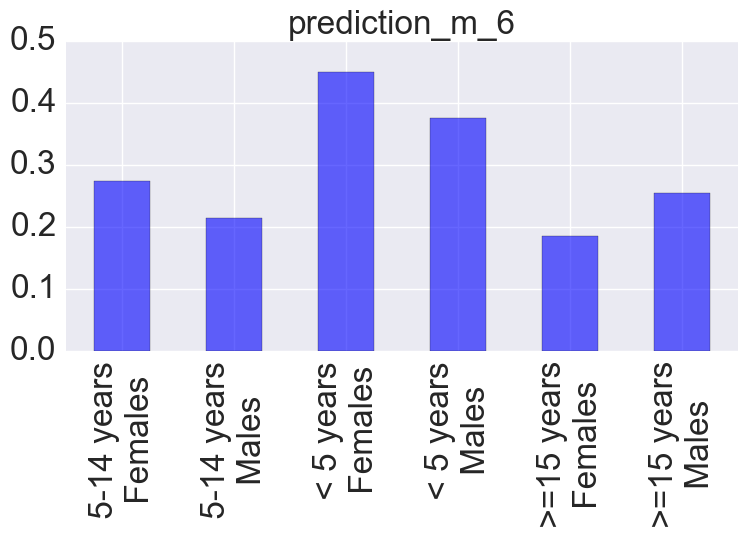

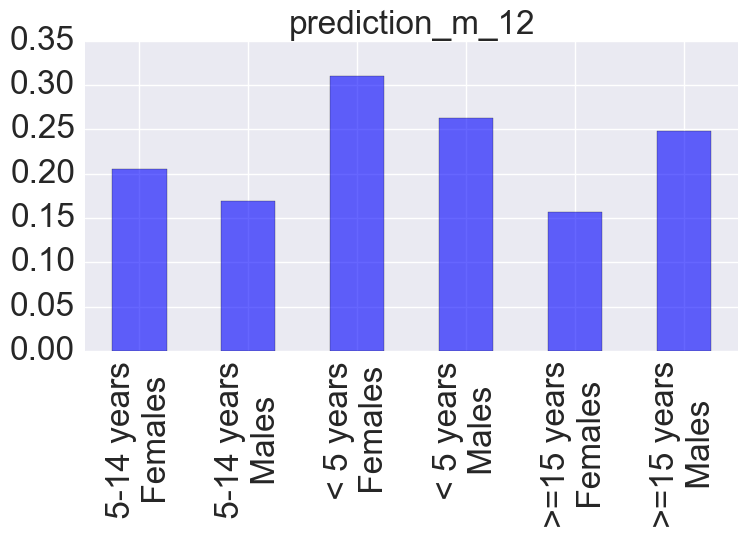

In [9]:
MODEL = BayesianRidge(n_iter=300)
TARGET = 'val'

dataframe, indicators, regions = load_data()

LAST_YEAR_REGION_POP = dataframe.groupby(['E_year', 'Region'])['pop'].mean().groupby(level=1).last()
LAST_YEAR_REGION_POP_WEIGHT = LAST_YEAR_REGION_POP / LAST_YEAR_REGION_POP.sum()

REGION_LIST = ['is_%s' % region for region in regions]
# Setup region groups
addis = ['addis ababa']
dire = ['dire dawa']
harari = ['harari']
others = [region for region in regions if region not in addis + dire + harari]
REGION_GROUPS = [addis, dire, harari, others]

# Start forecast 1 month prior, in case there is poor reporting in the current month
end_date = dataframe['E_Date'].max() - pd.offsets.relativedelta(months=1)

def predict_n_months(dataframe, MODEL, end_date, months=1):
    dataframes, predictions = [], []
    for month in range(1, months+1):
        DF_shift = setup_prediction_interval(dataframe, months=month)
        # Run for one n month shift:
        DF_shift_all, preds_all = zenprophet(DF_shift, MODEL, end_date, months=month)
        dataframes.append(DF_shift_all)
        predictions.append(preds_all)
    return dataframes, predictions

# Run main Function. Set the number of months forward to predict.
test_dataframes, predictions = predict_n_months(dataframe, MODEL, end_date, months=5)

# One was porduced for each forecast amount
good_columns = ['Real_Date', 'E_Date', 'Region', 'RegionName', 'Indicator', 'prediction', 'rmse', 'Indicator_id']
#testing_df = pd.concat(dataframes, ignore_index=True)
prediction_df = pd.concat([prediction[good_columns] for prediction in predictions], join='inner', ignore_index=True)
prediction_df.set_index('Region', inplace=True)

<h1> Make json or csv file for ingestion </h1>

In [10]:
# Load in region_mapped.csv file
REGION_DF = pd.read_csv('/Users/attiladobi/zenysis/pipeline/auto/ethiopia/bin/shared/data/region_mapped.csv', dtype=str)
REGION_DF.set_index('RegionName', inplace=True)

In [11]:
def make_composite(dataframe, pred_text):
    composite_val = dataframe.groupby(['Real_Date', 'RegionName'])[pred_text].sum()
    composite_sigma = dataframe.groupby(['Real_Date', 'RegionName'])\
        .apply(lambda x: np.sqrt(np.sum((x[pred_text] * x['rmse'])**2)))
    composit_val = composite_val.reset_index().rename(columns={0: 'val'})
    composit_sig = composite_sigma.reset_index().rename(columns={0: 'sigma'})
    composite_df = composit_val.merge(composit_sig, on=['Real_Date', 'RegionName'])
    composite_df['Indicator_id'] = 'composite_indicator_47'
    return composite_df

def write_dataframe_json(outfile, dataframe, pred_text, source, month, is_composite=False):
    if is_composite:
        dataframe = make_composite(dataframe, pred_text)
    else:
        dataframe['sigma'] = dataframe[pred_text] * dataframe['rmse']
    try:
        dataframe['Real_Date'] = [date.strftime('%Y-%m-%d') for date in dataframe['Real_Date']]
    except AttributeError:
        print 'Date is already a string'
    # Write to json
    for line in dataframe.iterrows():
        line = line[1]
        region = line['RegionName']
        lat = float(REGION_DF.loc[region]['RegionLat'])
        lon = float(REGION_DF.loc[region]['RegionLon'])
        field = '%s_%s' % (source, line['Indicator_id'])
        if month > 1:
            field = '%s_%sm_%s' % (source, month, line['Indicator_id'])
        json.dump(OrderedDict([('Real_Date', line['Real_Date']), ('RegionName', region), \
                   ('val', line[pred_text]), ('field', field), \
                   ('source', source), ('RegionLat', lat), \
                   ('RegionLon', lon)]), outfile)
        outfile.write('\n')
        # Write 1 sigma error
        field = '%s_error_%s' % (source, line['Indicator_id'])
        if month > 1:
            field = '%s_%sm_error_%s' % (source, month, line['Indicator_id'])
        json.dump(OrderedDict([('Real_Date', line['Real_Date']), ('RegionName', region), \
           ('val', line['sigma']), ('field', field), \
           ('source', source), ('RegionLat', lat), \
           ('RegionLon', lon)]), outfile) 
        outfile.write('\n')

<h1> Write to json </h1>

In [21]:
pred_texts = ['prediction_m_6', 'prediction']
SOURCE = 'forecast'

# month is months forward to predict. Want to save data for 1 and 3 months
with open("forecast_new.json", "w") as outfile:
    for month in [1, 3]:
        # Set month_shift to 6 months back, can also do 2 for 12 months
        month_shift = PRED_SHIFTS[1]
        df_tests = test_dataframes[month-1]
        date_min = end_date - pd.offsets.relativedelta(months=month_shift)
        df_tests = df_tests[(df_tests['E_Date'] > date_min) & (df_tests['E_Date'] <= end_date)]

        dfs_to_write = [df_tests, prediction_df]
        for dataframe, pred_text in zip(dfs_to_write, pred_texts):
            write_dataframe_json(outfile, dataframe, pred_text, SOURCE, month)
            write_dataframe_json(outfile, dataframe, pred_text, SOURCE, month, is_composite=True)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Date is already a string
Date is already a string
Date is already a string
Date is already a string
Date is already a string


<h1> Loop through and plot all regions and indicators for sanity checks </h1>

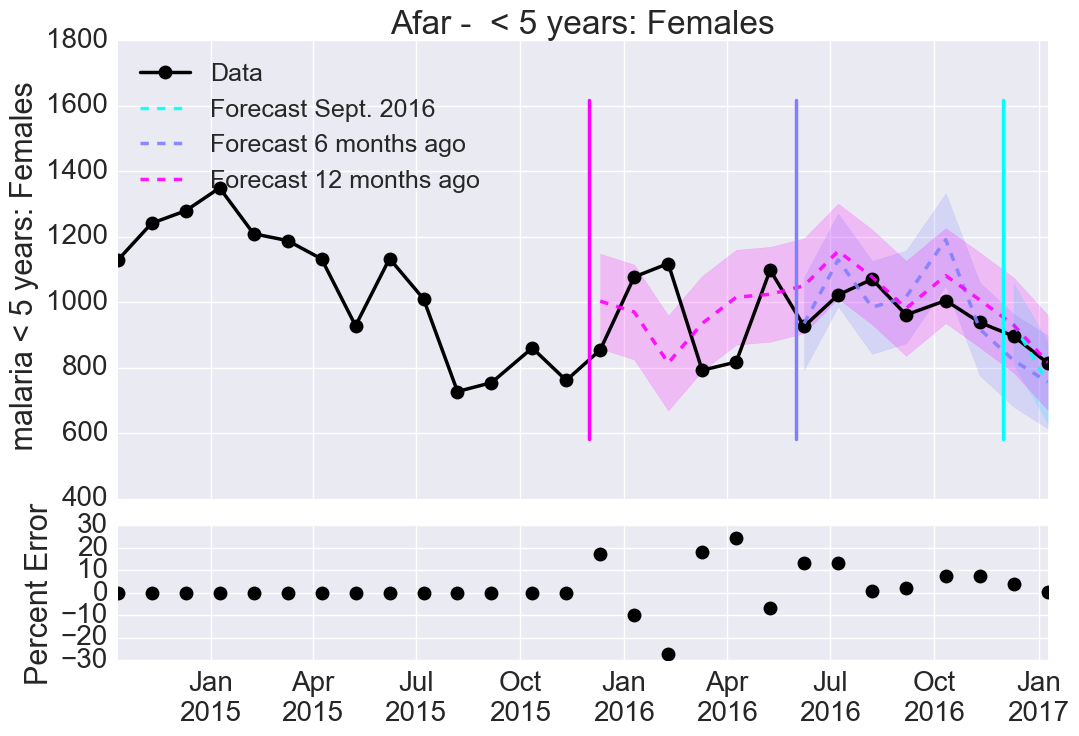

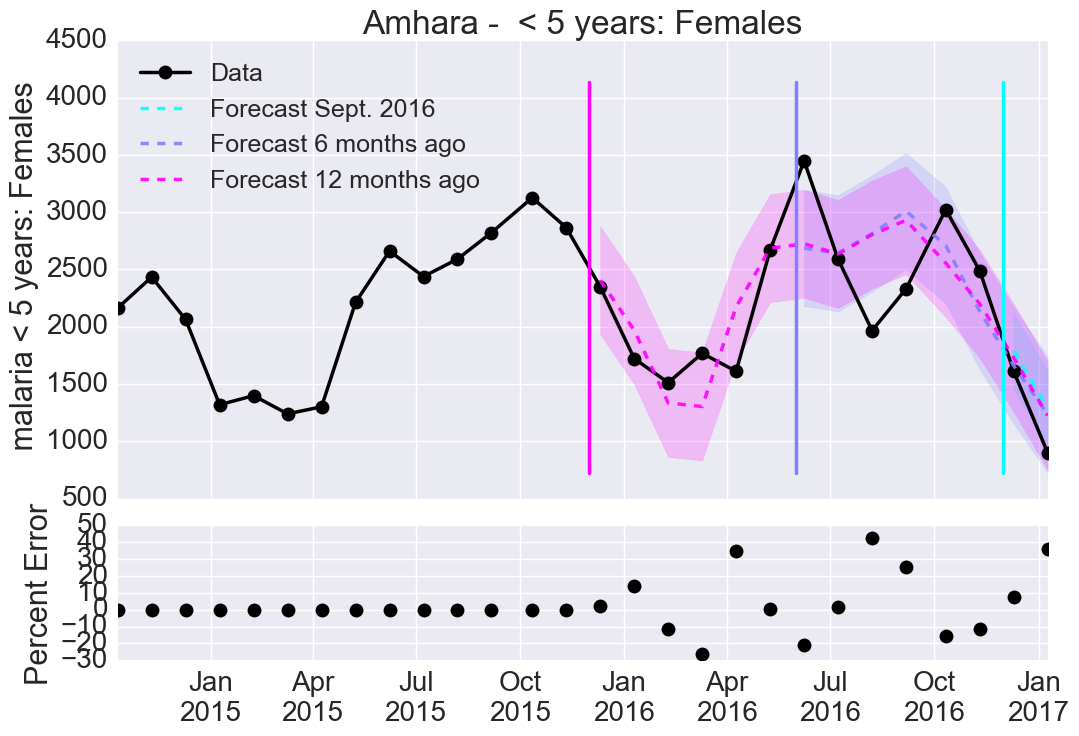

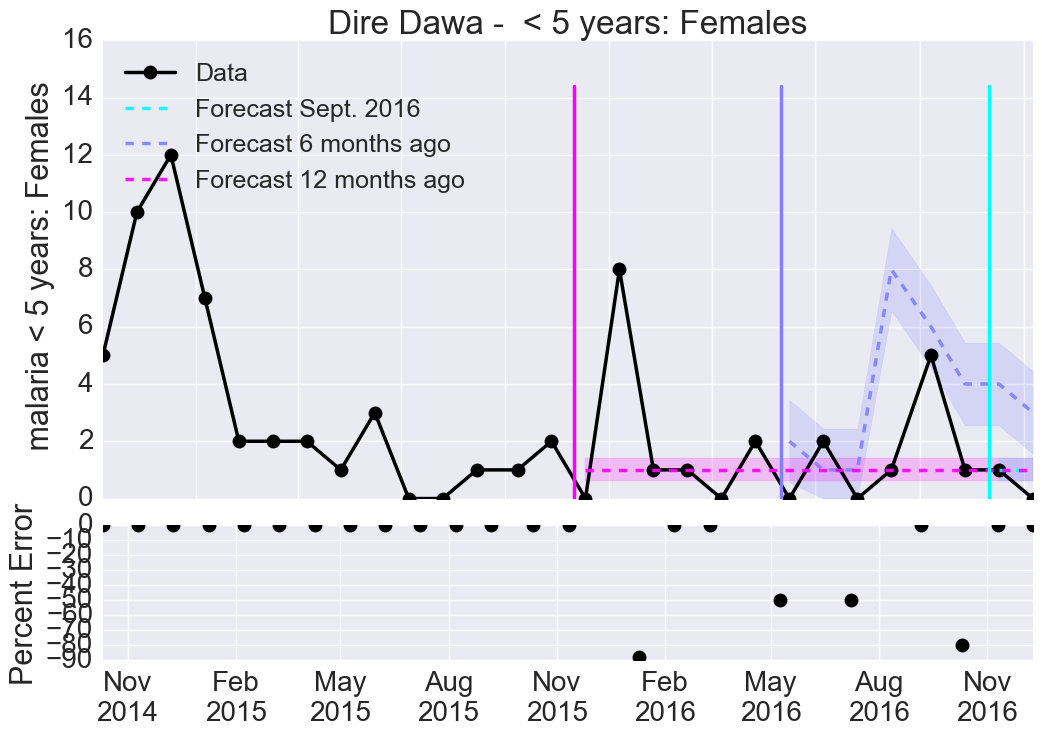

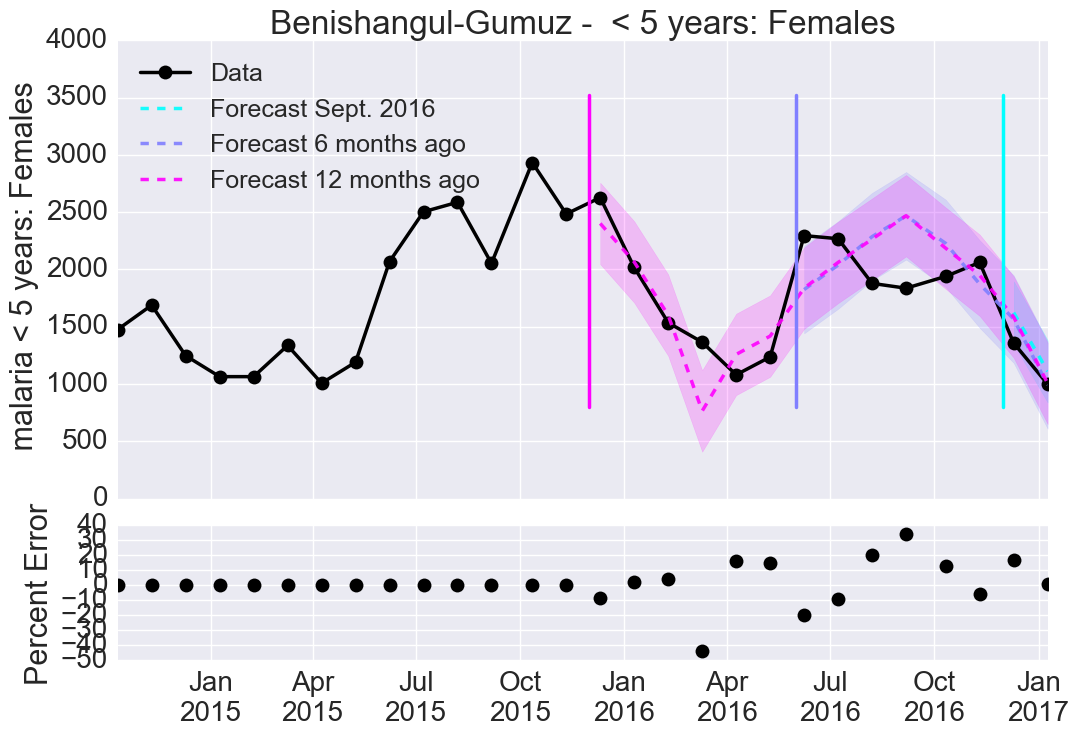

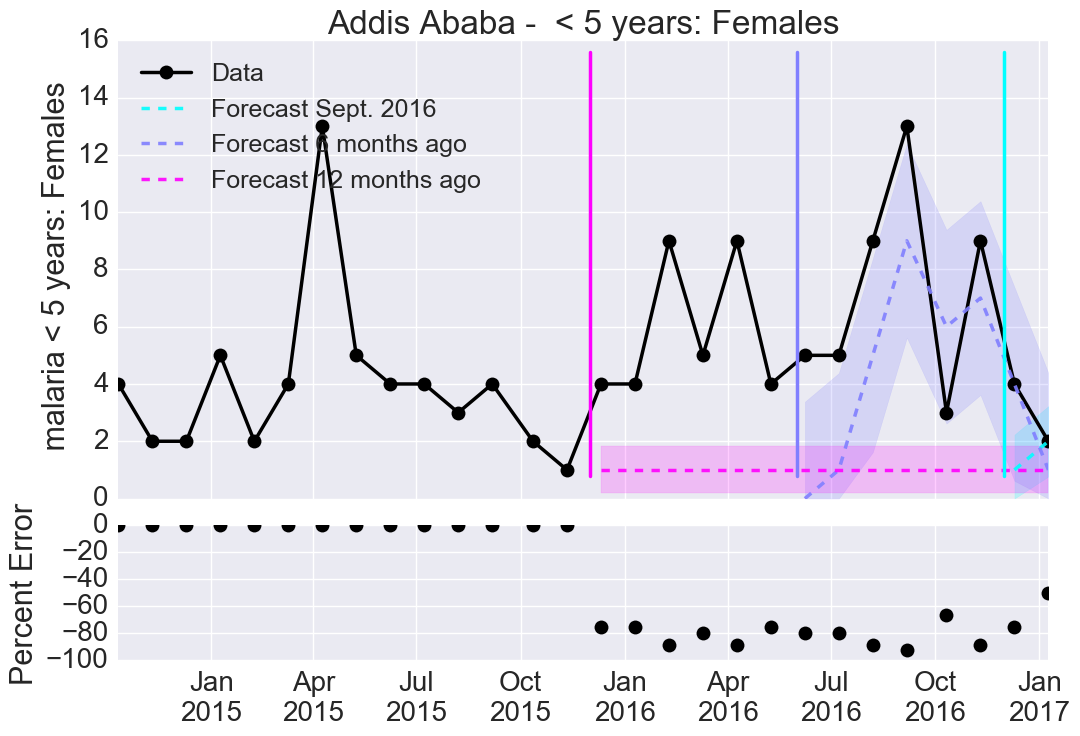

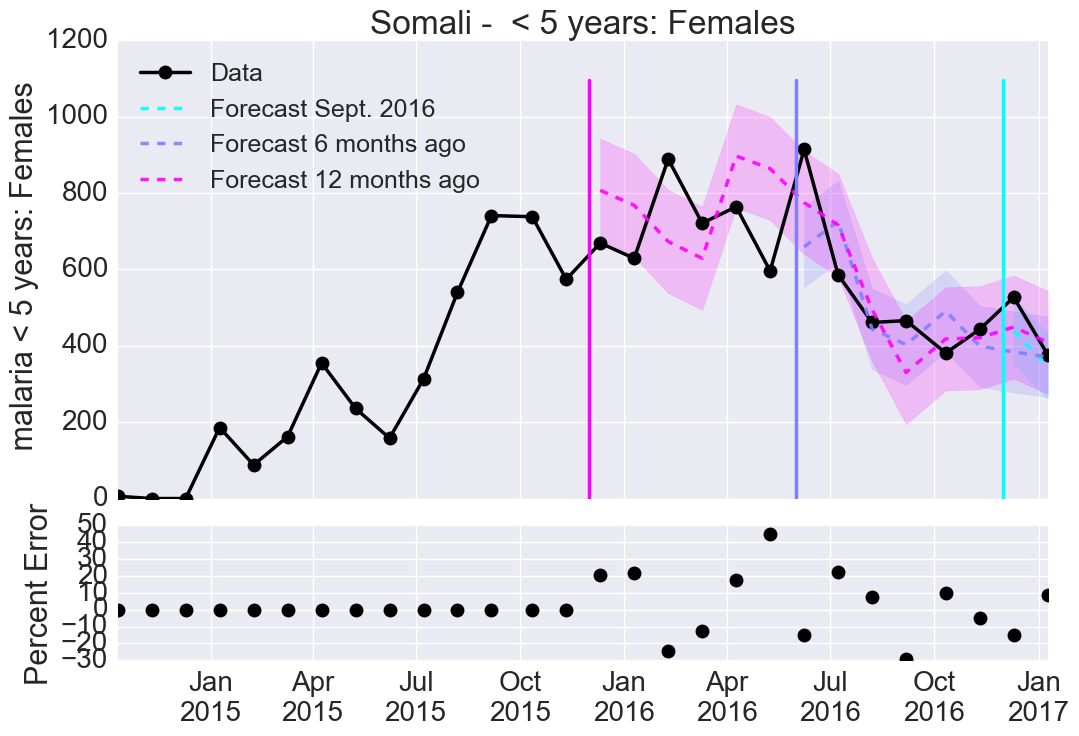

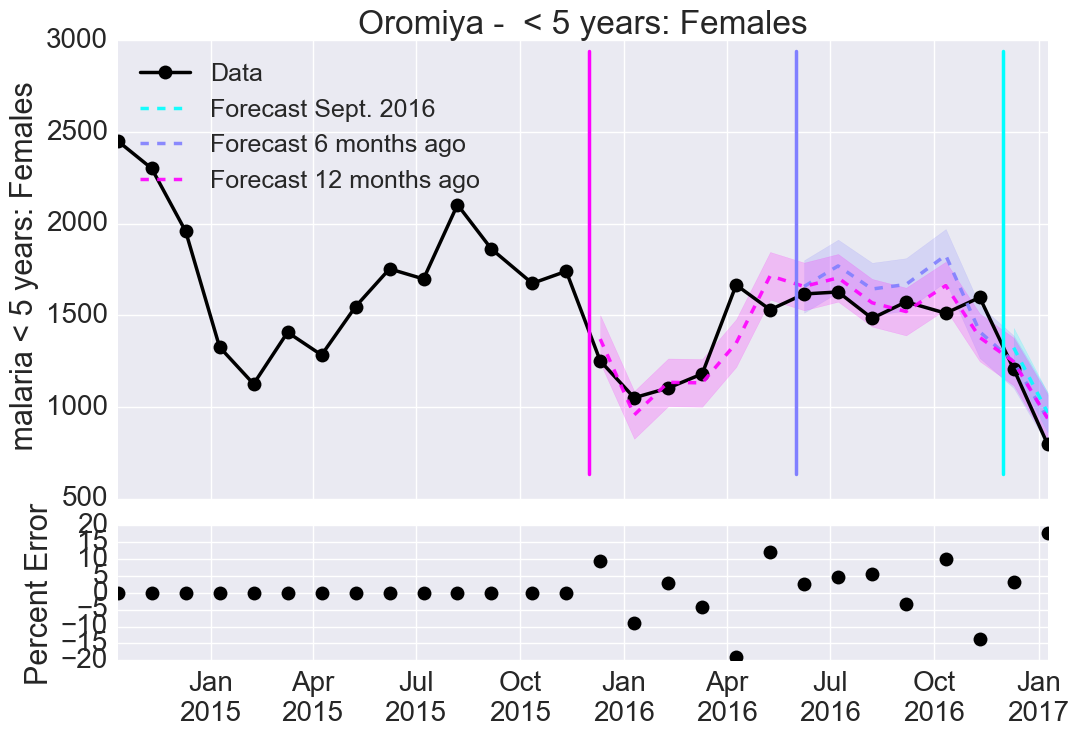

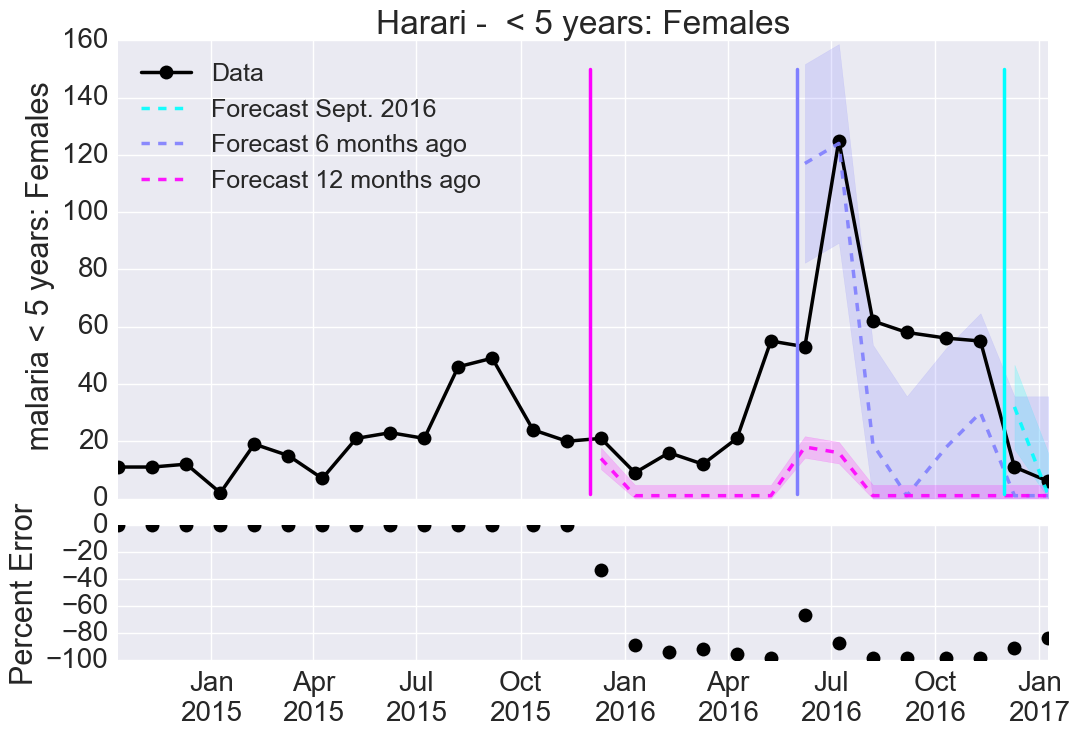

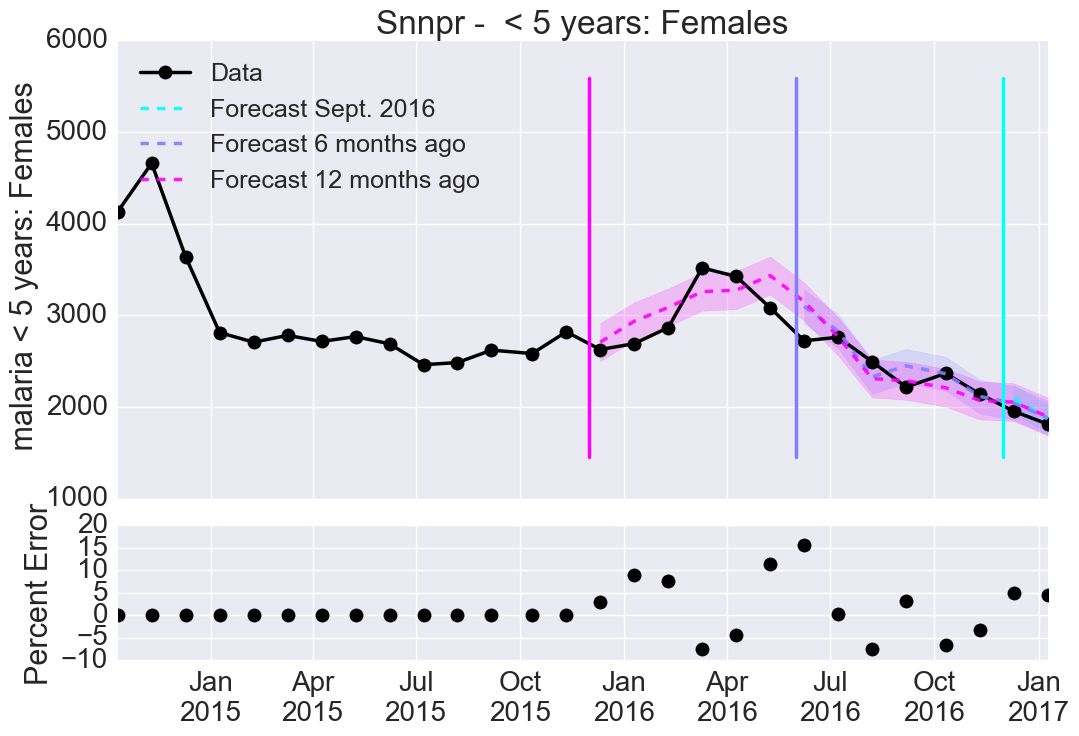

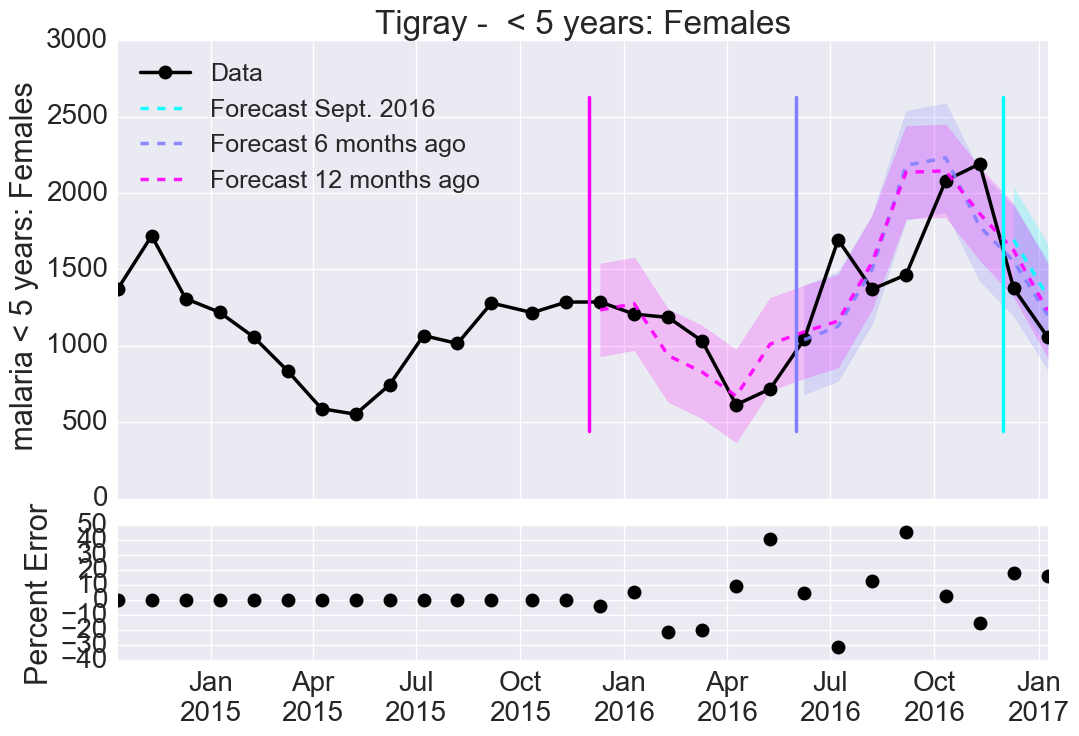

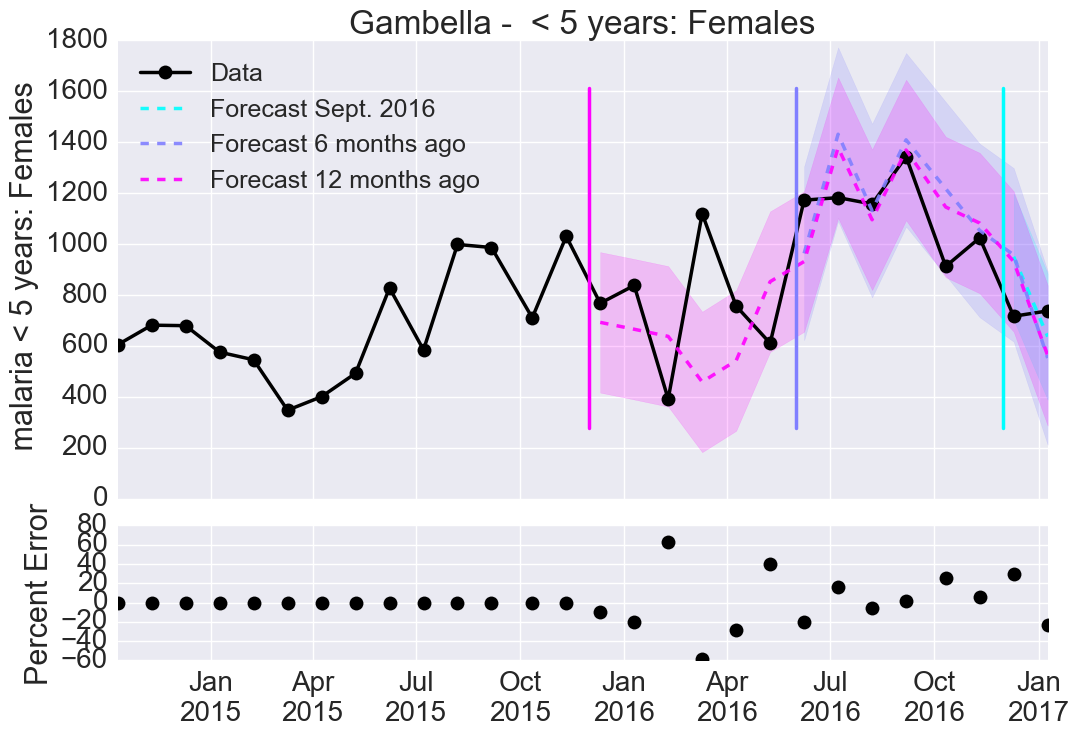

In [30]:
for month in range(1,2):
    savedir = 'Bayes_tests_malaria_m_%s' % month
    if not os.path.exists(savedir):
        os.mkdir(savedir)
    
    df = test_dataframes[month-1].set_index(['Region'])
    M = month
    horz_lines = [(2016, 12 - (M-1)), (2016, 6 - (M-1)), (2015, 12 - (M-1)), (2015, 6 - (M-1))][:len(PRED_SHIFTS)]
    training_end = (end_date.year, end_date.month - 1)
    pred_text = ['Forecast Sept. 2016', 'Forecast 6 months ago', 'Forecast 12 months ago']

    for region in regions:
        for indicator in indicators[1:2]:
            to_plot, predict_plot, RMSE_n = plot_testings_nation(df.loc[region], \
                            indicator, date_type='Real_Date', val_name='val',\
                            pred_name = 'prediction', pred_shifts=PRED_SHIFTS, training_end = training_end,  \
                            horz_lines = horz_lines, cf_band=True, cmap=cm.cool, \
                            title= '%s - %s' % (region.title(), indicator.split('malaria')[-1]), pred_text=pred_text)
            #plt.savefig('%s/%s_%s.png' % (savedir, region, indicator))
            #plt.clf()

<h1> Can loop through all the dataframes, each one is a different number of months forward </h1>

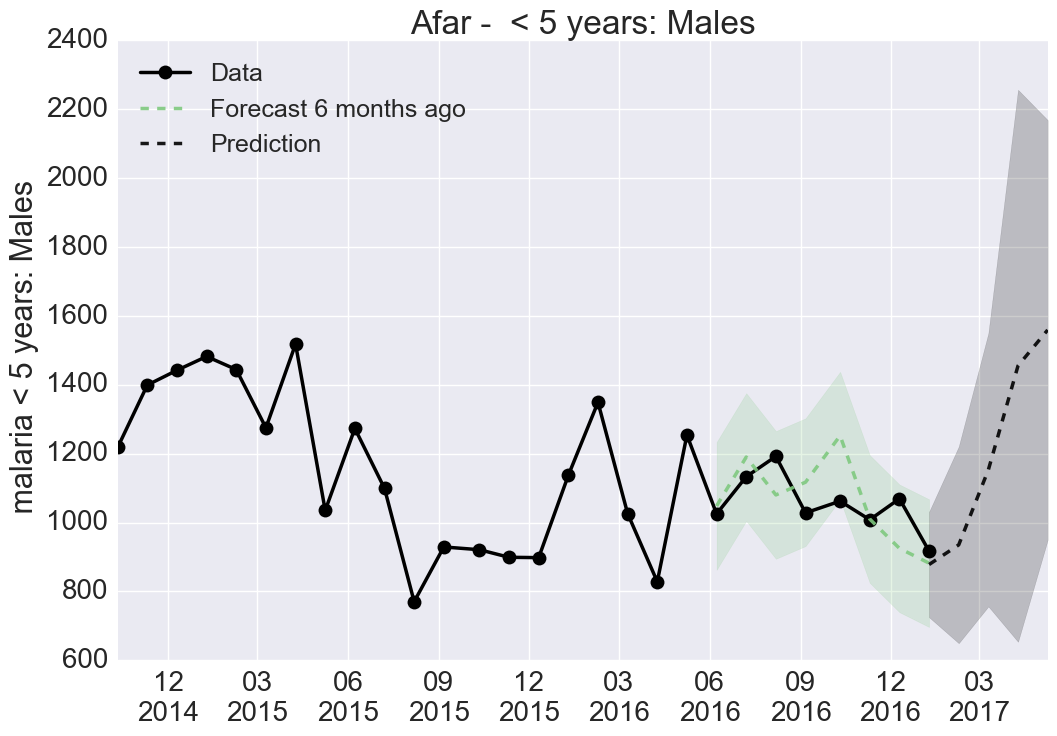

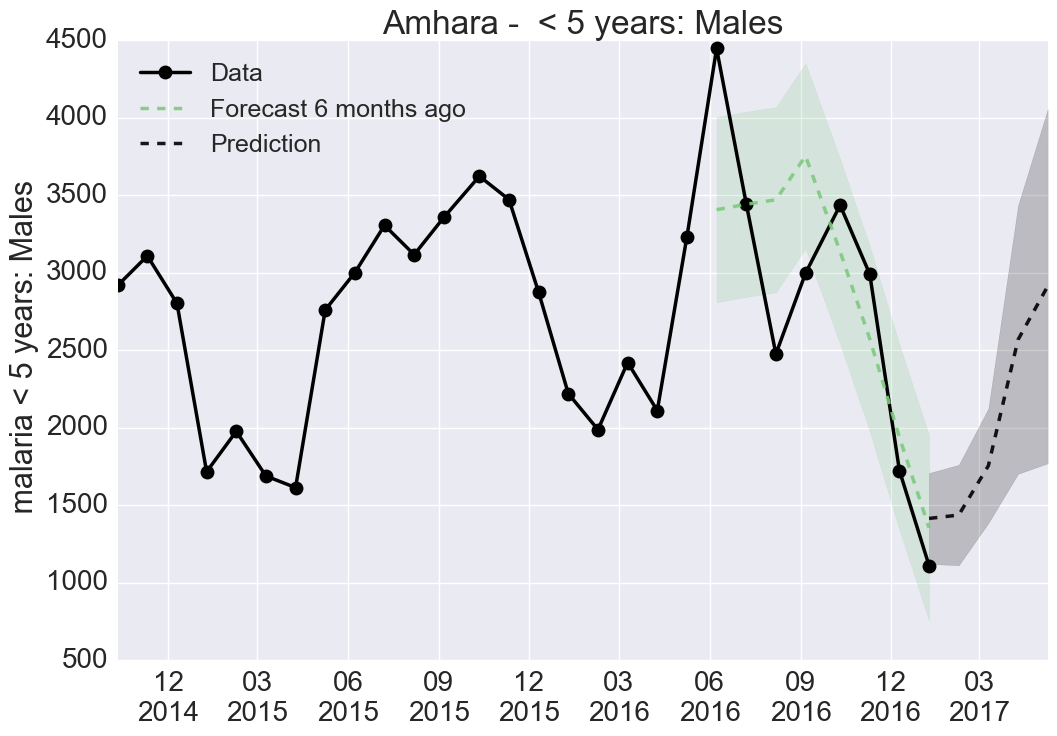

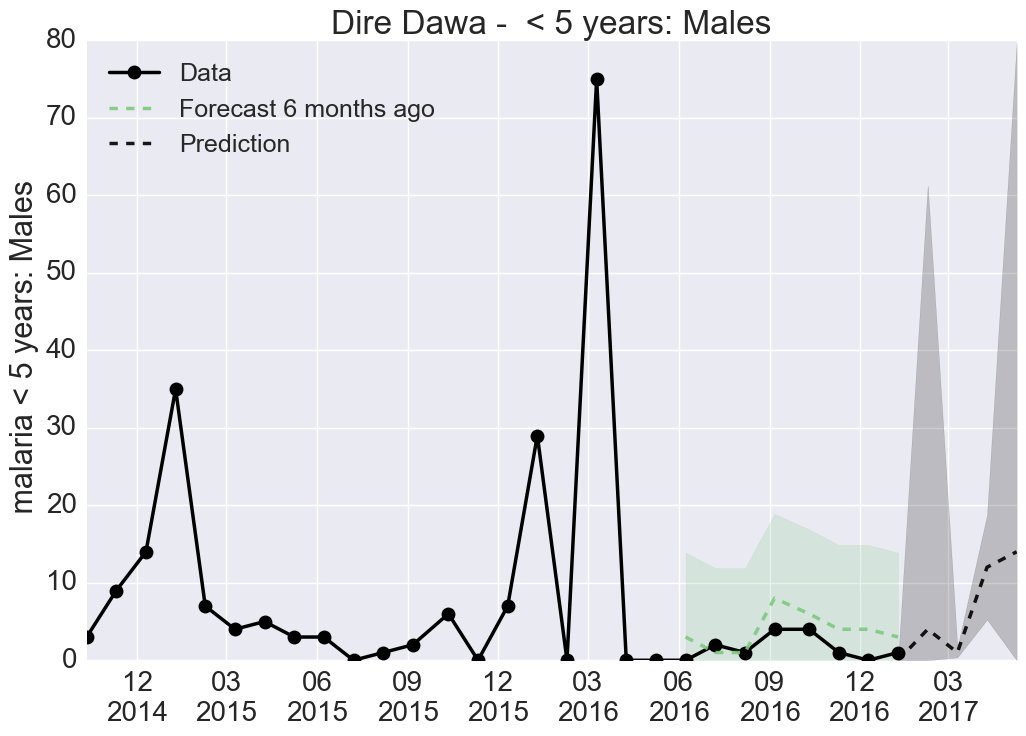

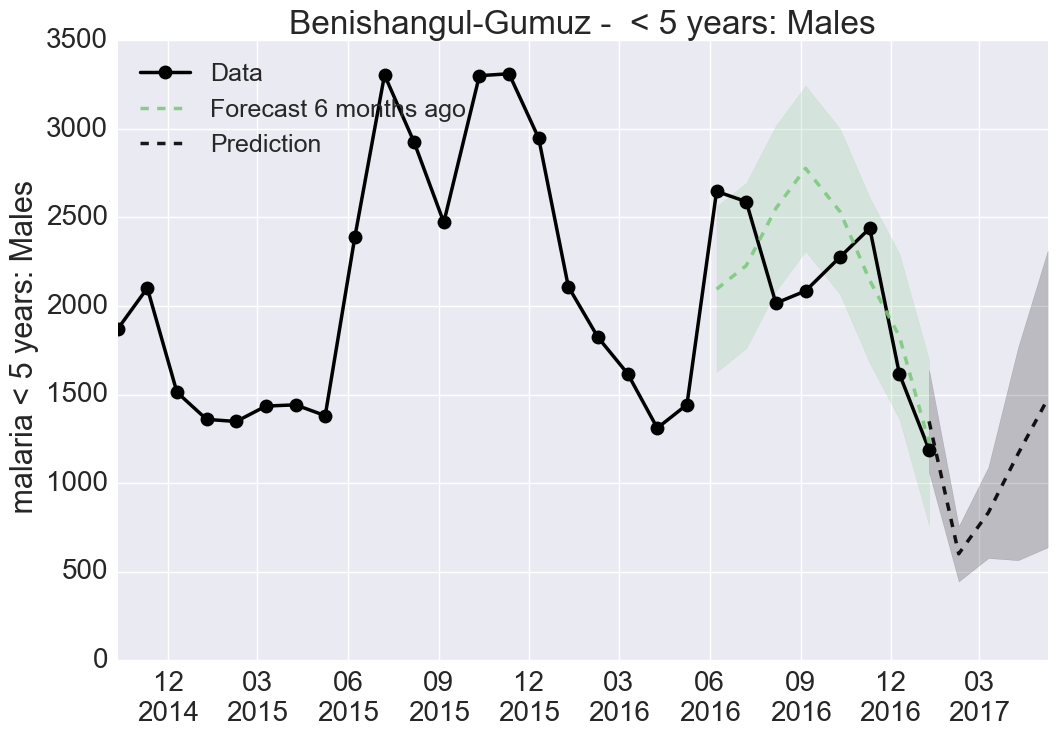

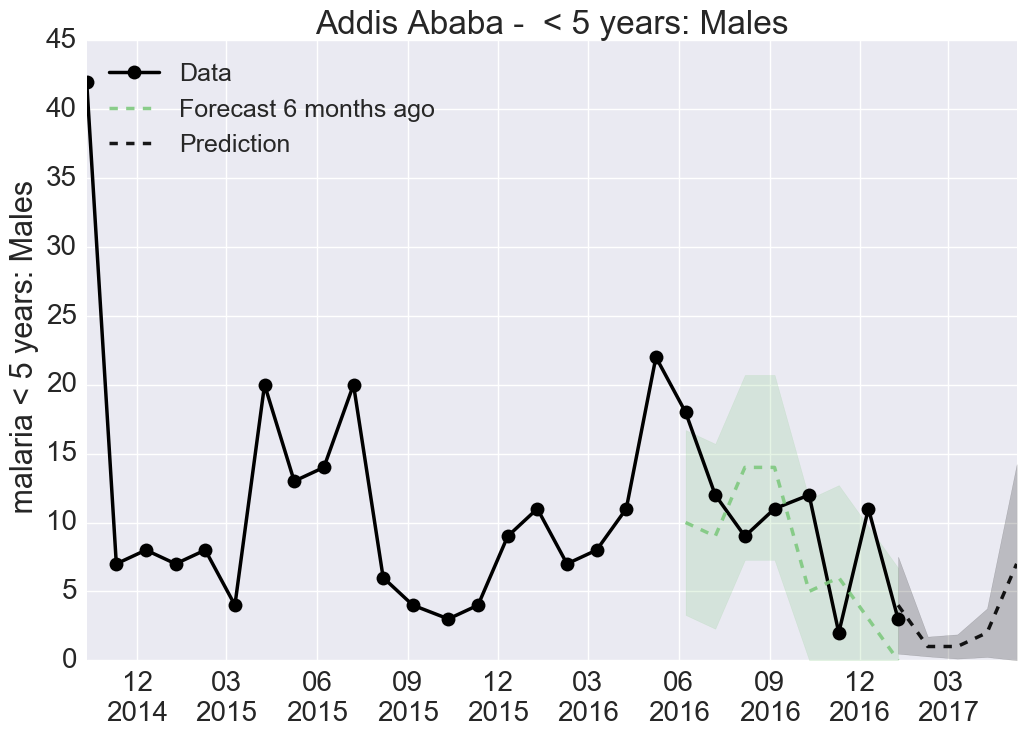

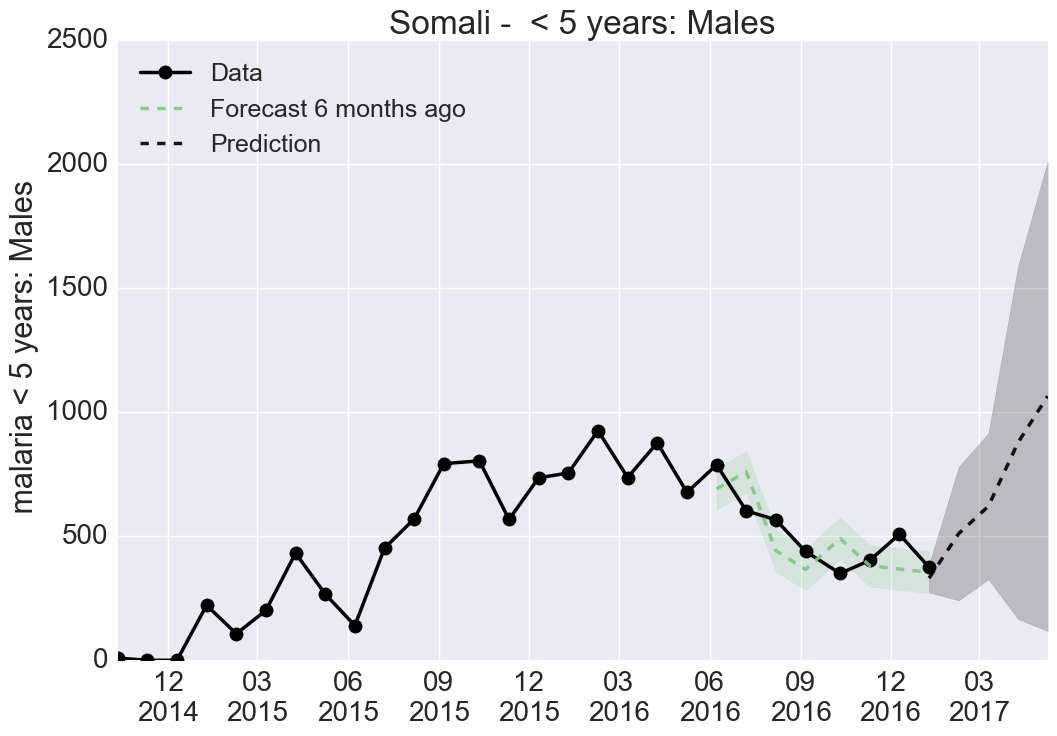

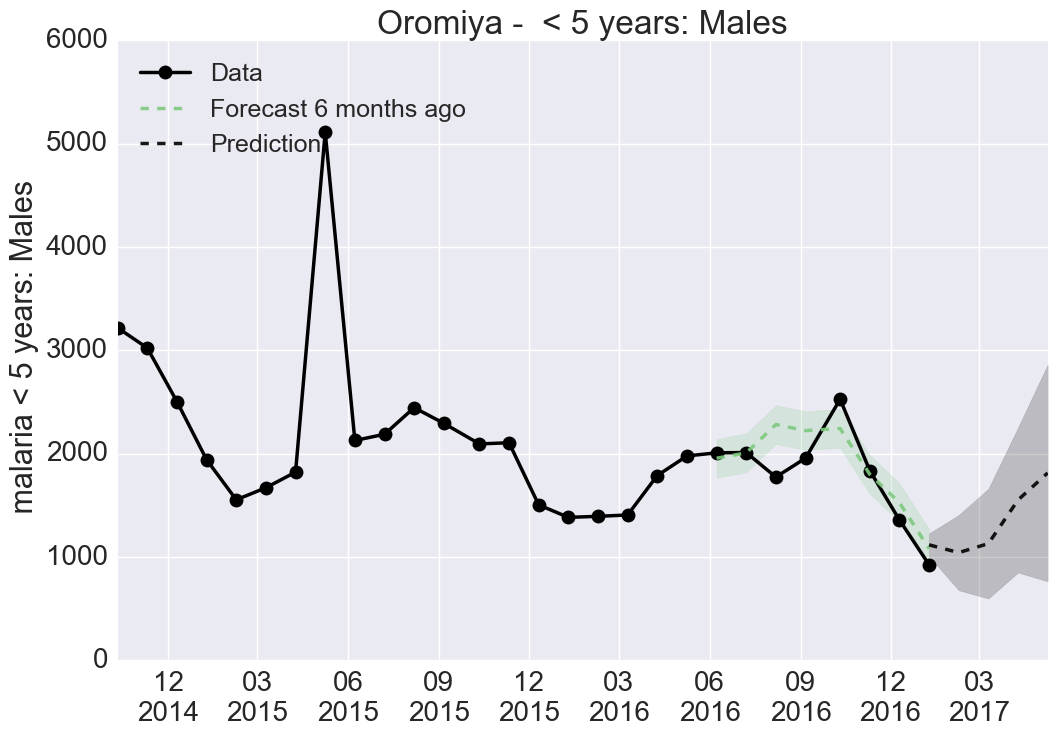

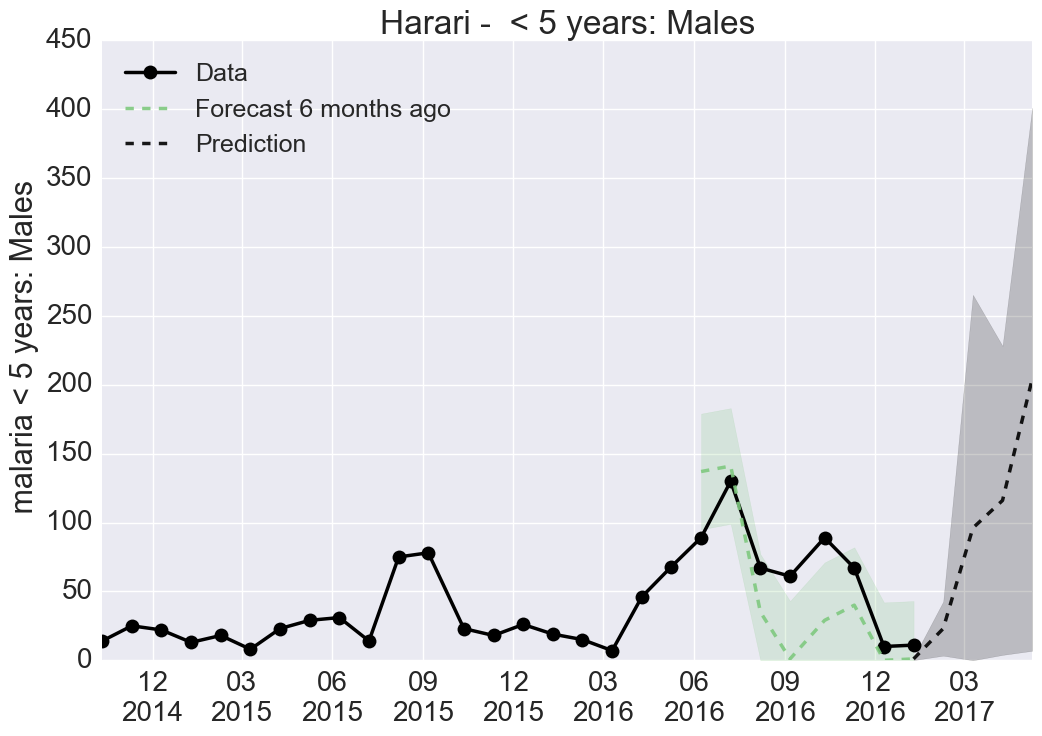

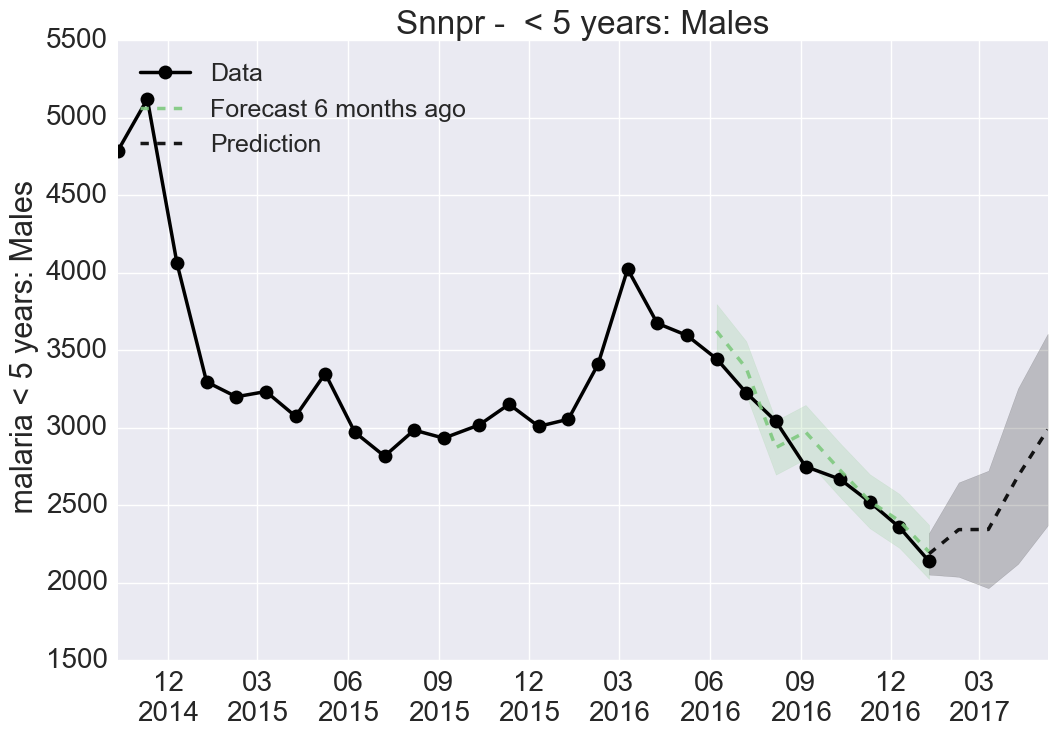

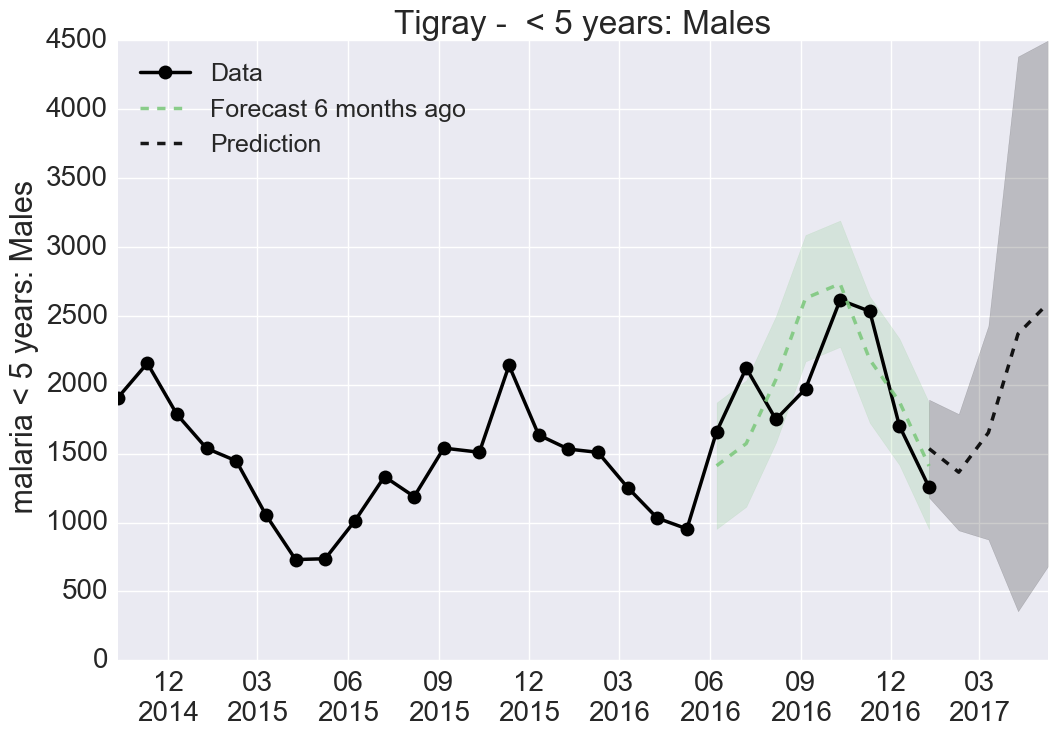

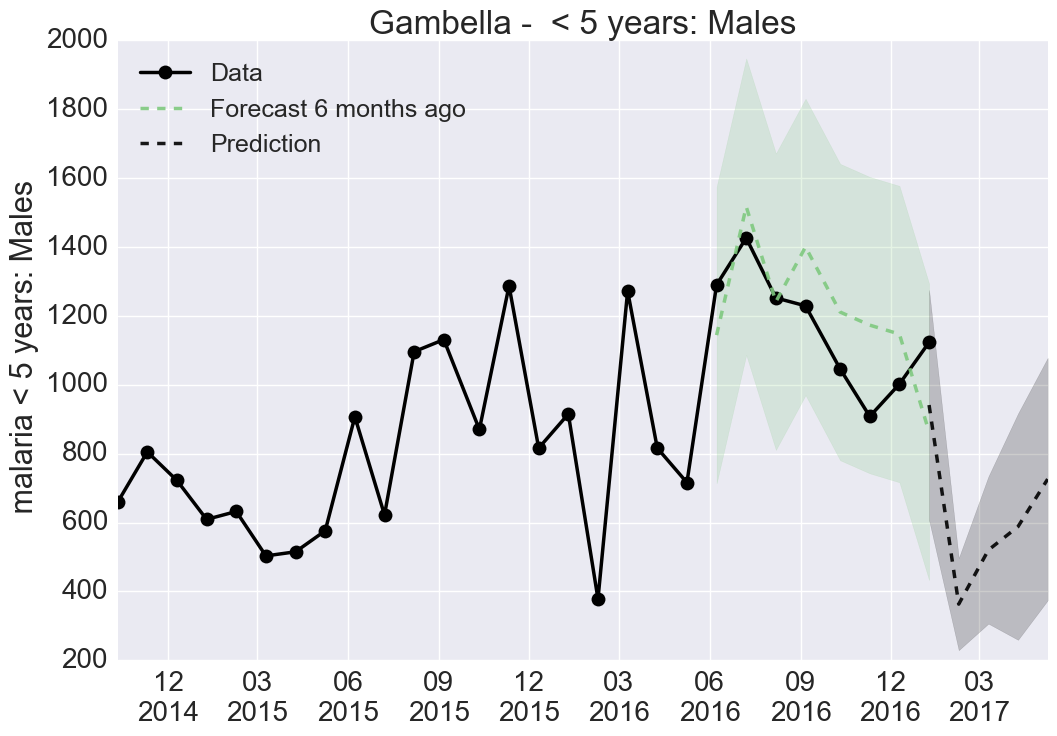

In [51]:
month = 1
savedir = 'Bayes_forecast_malaria_m_%s' % month
if not os.path.exists(savedir):
    os.mkdir(savedir)
df = test_dataframes[month-1].set_index(['Region'])

for region in regions:
    for indicator in indicators[:1]:
        a = plot_test_and_forecast(df.loc[region], prediction_df.loc[region], indicator, pred_shifts=PRED_SHIFTS[1:2], \
                        training_end = training_end, cf_band=True, date_type='Real_Date', \
                        title= '%s - %s' % (region.title(), indicator.split('malaria')[-1]), pred_text=pred_text[1:2])
        #plt.savefig('%s/%s_%s.png' % (savedir, region, indicator))
        #plt.clf()

<h1> View national level </h1>

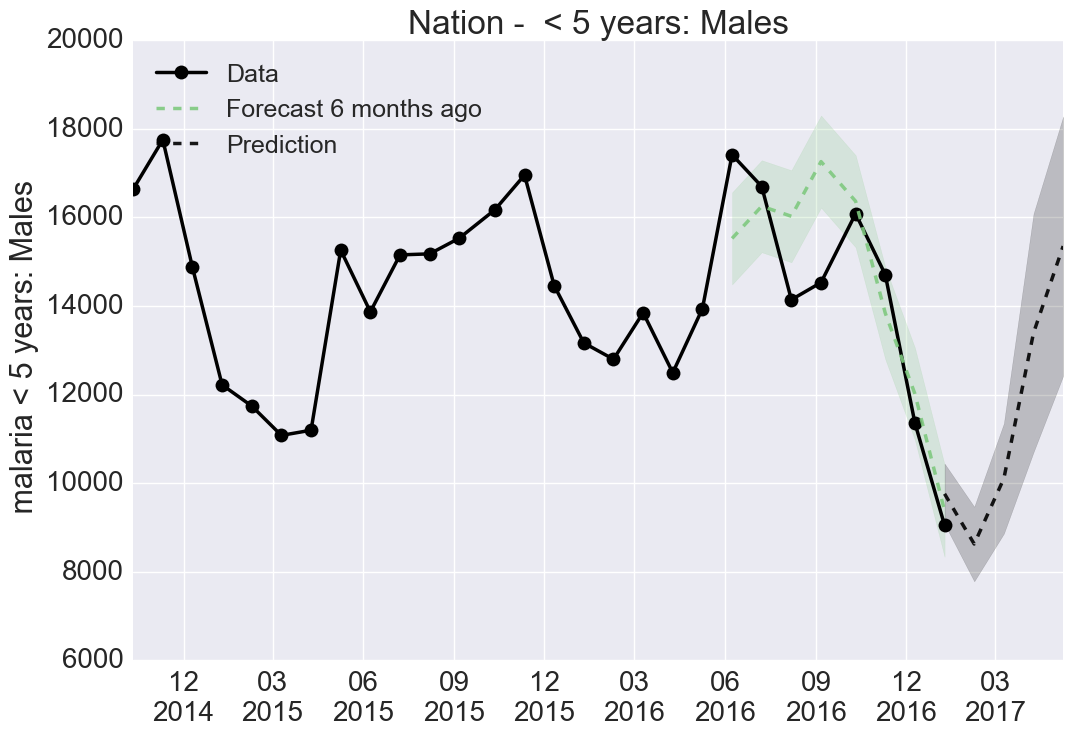

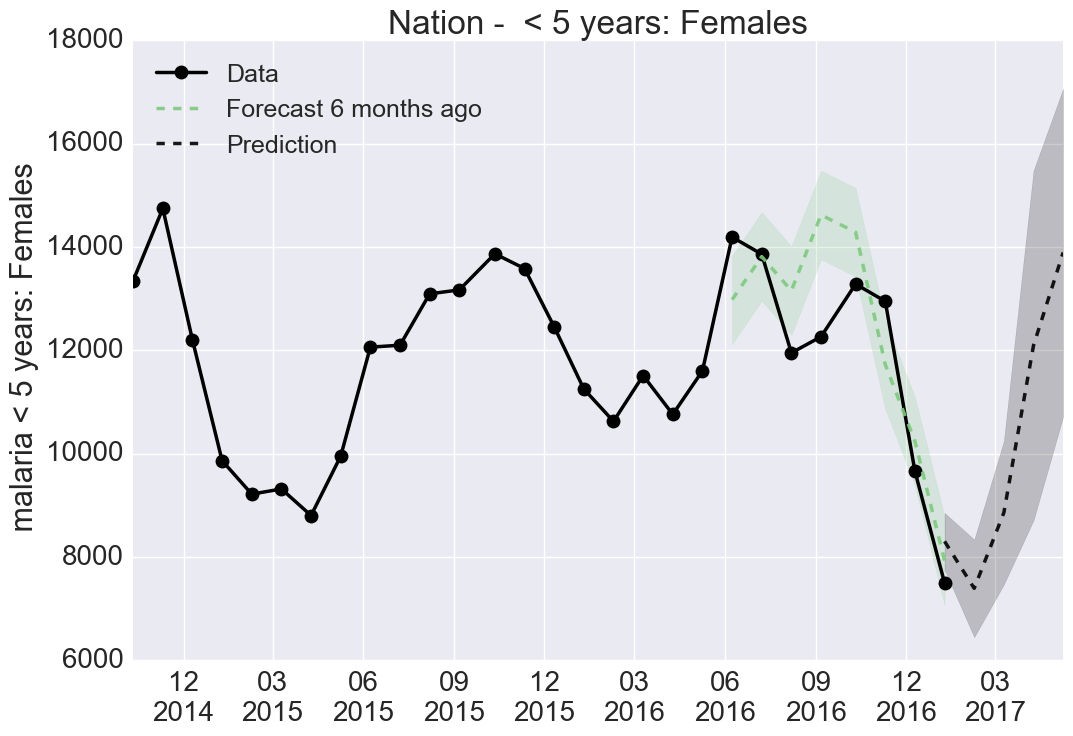

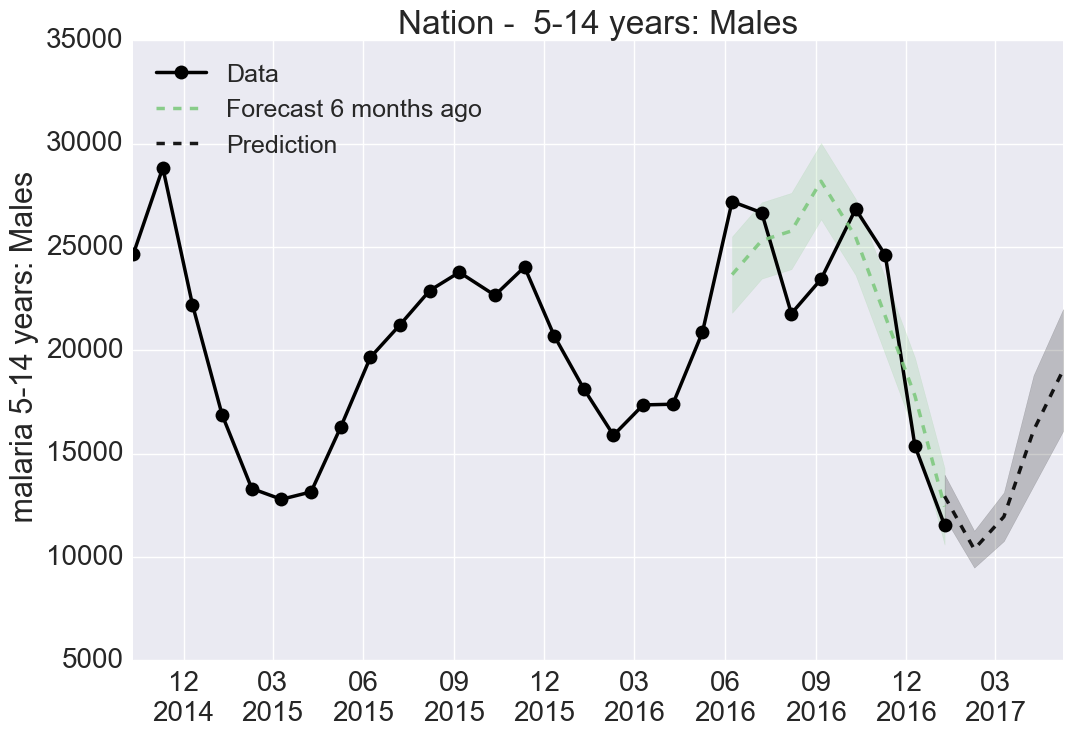

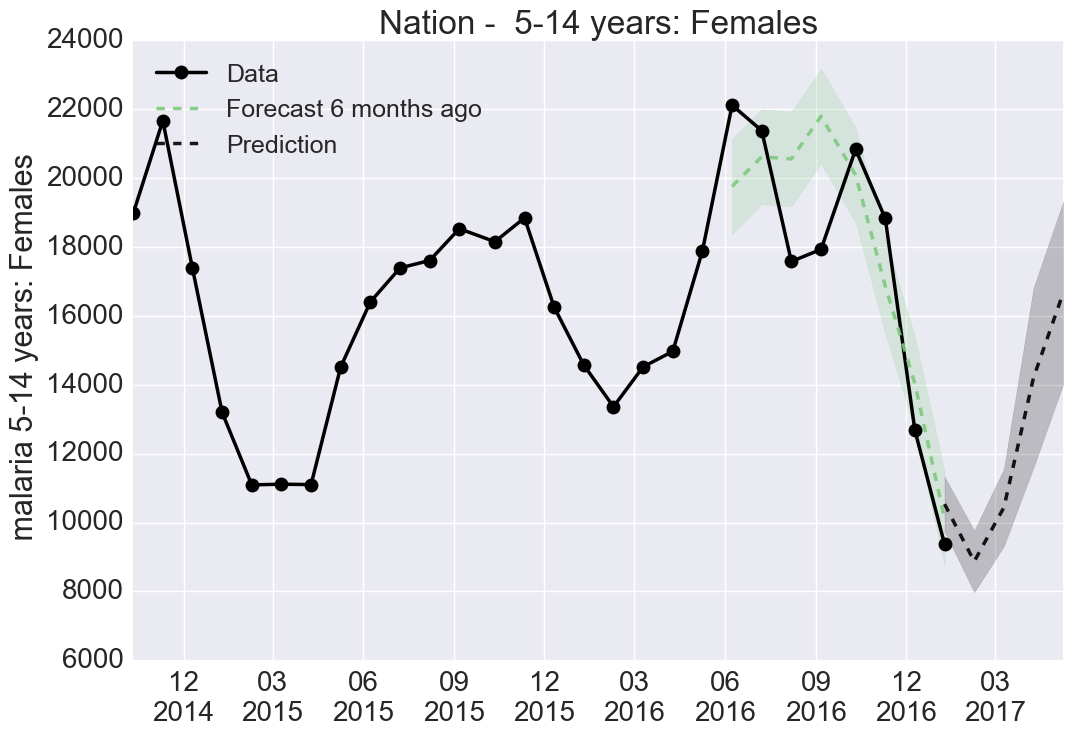

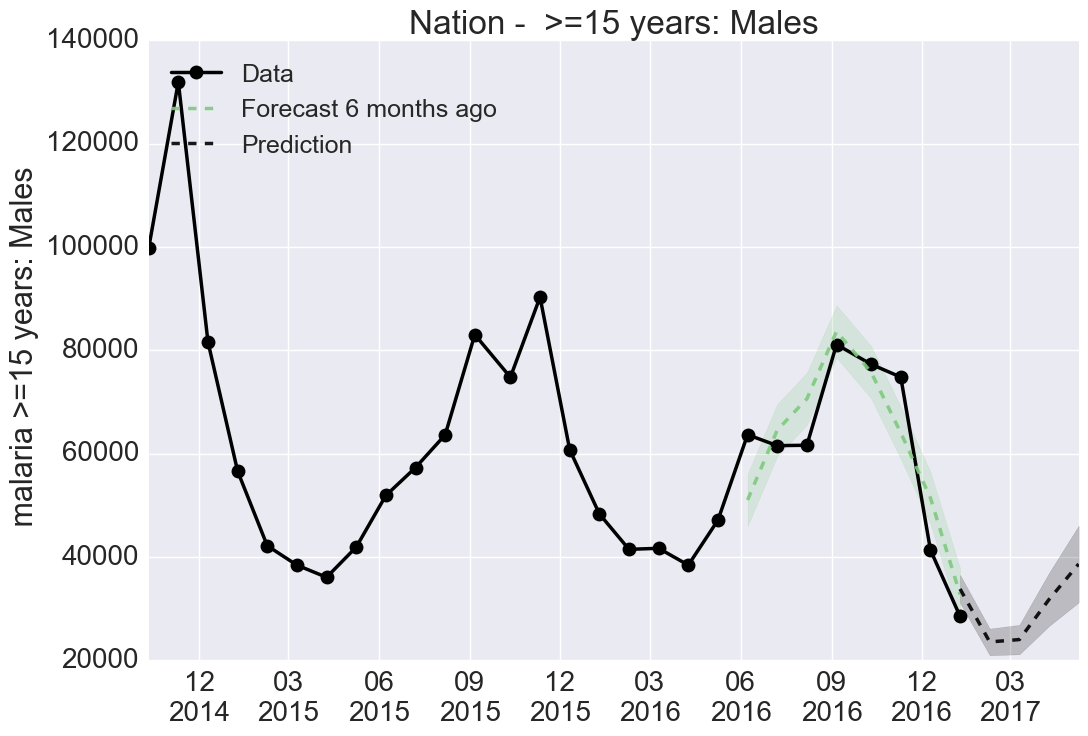

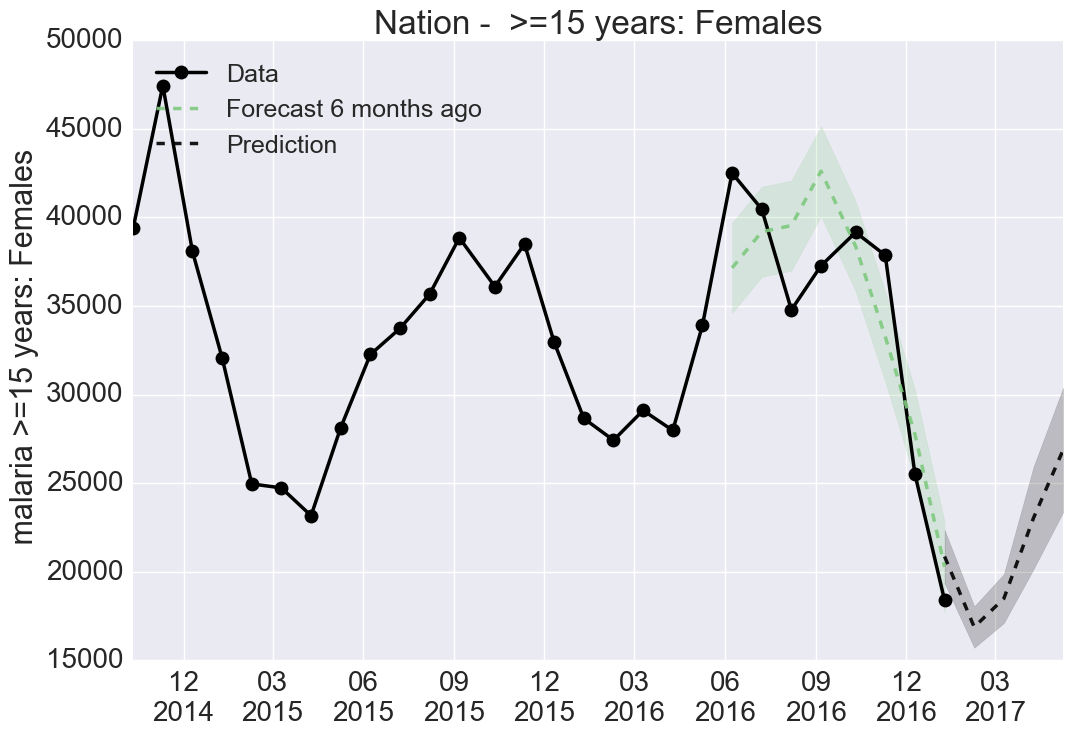

In [52]:
month = 1
savedir = 'Bayes_forecast_Nation_malaria_m_%s' % month
if not os.path.exists(savedir):
    os.mkdir(savedir)
df = test_dataframes[month-1].set_index(['Region'])

for indicator in indicators:
        a = plot_test_and_forecast(df, prediction_df, indicator, pred_shifts=PRED_SHIFTS[1:2], \
                        training_end = training_end, cf_band=True, date_type='Real_Date', \
                        title= '%s - %s' % ('Nation', indicator.split('malaria')[-1]), pred_text=pred_text[1:2])
        #plt.savefig('%s/%s_%s.png' % (savedir, 'Nation', indicator))
        #plt.clf()
        
# Add all regions to a single plot.

<h1> Plot results </h1>

In [26]:
# Plotting code
from plot_util import *

In [35]:
def plot_testings_nation(dataframe, indicator, date_type='E_Date', val_name='val', pred_name = 'prediction', \
                         pred_shifts = [0], training_end = (2008, 1), horz_lines = [(2007,1)], ylab=None, cf_band=False, \
                         cmap = pylab.cm.Accent, title = 'National', pred_text=None):
    # Setup colors for forecasts:
    start, stop=0, 1
    cm_subsection = np.linspace(start, stop, len(pred_shifts))
    colors = [cmap(x) for x in cm_subsection]
    
    # Plot the indicator values
    to_plot = dataframe.loc[dataframe['Indicator'] == indicator].reset_index().groupby([date_type])[val_name].sum()
    ylab_text = indicator.split('for')[-1]
    
    fig=pylab.figure()
    fig.set_size_inches(12, 8)
    sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})

    plt.subplot2grid((4,1), (0,0), rowspan=3)
    x, y = pd_proper_dateformat(to_plot)
    plt.plot_date(x, y, '.-', color='k', markersize=20, label='Data',)
    plt.title(title)
    
    # Plot the predictions
    for i, mshift in enumerate(pred_shifts):
        # add postfix to prediction name
        date_min = pd.datetime(training_end[0], training_end[1], 1) - pd.offsets.relativedelta(months=mshift)
        pred_str = pred_name
        if mshift > 0:
            pred_str = '%s_m_%s' % (pred_name, mshift)
        predict_plot = dataframe.loc[(dataframe['Indicator'] == indicator) \
            & (dataframe['E_Date'] > date_min)].reset_index().groupby([date_type])[pred_str].sum()
        pred_lab_text = pred_str
        xp, yp = pd_proper_dateformat(predict_plot)
        #add custom labels
        if pred_text:
            plt.plot_date(xp, yp, '--', color=colors[i], markersize=20, label=pred_text[i], alpha = 0.9)
        else:
            plt.plot_date(xp, yp, '--', color=colors[i], markersize=20, label=pred_str, alpha = 0.9)
        # Add 1 sigma region:
        if cf_band:
            sigma = return_sigma(dataframe, pred_str, indicator, date_min, date_type)
            yp_upper = yp + sigma
            yp_lower = [max(val, 0) for val in yp - sigma]
            plt.fill_between(xp, yp_lower, yp_upper, color = colors[i], alpha = 0.2, interpolate=True)
            #print predict_upper
        
    if ylab:
        pylab.ylabel(ylab)
    else:
        pylab.ylabel(ylab_text)
        
    #pylab.xlabel('Date')
    pylab.legend(loc='upper left', numpoints=1, fontsize=18)
    ax = pylab.gca()
    # Remove x labels
    ax.tick_params(labelbottom='off')
    #ax.xaxis.set_major_formatter(pylab.matplotlib.dates.DateFormatter('%m-%Y'))
    #ax.xaxis.set_major_formatter(pylab.matplotlib.dates.DateFormatter('%m\n%Y'))
    
    # Add horizontal lines:
    for i, horz_line in enumerate(horz_lines):
        plt.plot_date(['%s-%s-01' % horz_line, '%s-%s-01' % horz_line],[to_plot.min()*0.8, to_plot.max()*1.2],\
                      '-', color = colors[i])
    
    plt.subplot2grid((4,1), (3,0))
    
    #RMSE_n = np.mean(np.sqrt((predict_plot - to_plot)**2) / to_plot)
    RMSE_n = np.sqrt( np.mean((predict_plot - to_plot)**2) ) / np.mean(to_plot)
    x, y = pd_proper_dateformat( ((predict_plot - to_plot) * 100 / to_plot).replace(np.nan,0) )

    plt.plot_date(x, y, '.', color='k', markersize=20, label='percent error',)
    #pylab.legend(loc='upper right', numpoints=1,fontsize=12)
    #plt.text(max(x), max(y), 'Norm RMSE = %s' % RMSE_n *100)
    
    pylab.ylabel('Percent Error')
    ax = pylab.gca()
    ax.xaxis.set_major_formatter(pylab.matplotlib.dates.DateFormatter('%b\n%Y'))
    #ax.xaxis.set_major_formatter(pylab.matplotlib.dates.DateFormatter('%m-%Y'))
    #pylab.xlabel('Date')
    
    return to_plot, predict_plot, RMSE_n

In [50]:
def plot_test_and_forecast(dataframe, df_predict, indicator, date_type='E_Date', val_name='val', pred_name = 'prediction', \
                         pred_shifts = [0], training_end = (2008, 1), horz_lines = [(2007,1)], ylab=None, cf_band=False, \
                         cmap = pylab.cm.Accent, title = 'National', pred_text=None):
    # Setup colors for forecasts:
    start, stop = 0, 1
    cm_subsection = np.linspace(start, stop, len(pred_shifts))
    colors = [cmap(x) for x in cm_subsection]
    
    # Plot the indicator values
    to_plot = dataframe.loc[dataframe['Indicator'] == indicator].reset_index().groupby([date_type])[val_name].sum()
    ylab_text = indicator.split('for')[-1]
    
    fig=pylab.figure()
    fig.set_size_inches(12, 8)
    sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})

    x, y = pd_proper_dateformat(to_plot)
    plt.plot_date(x, y, '.-', color='k', markersize=20, label='Data',)
    plt.title(title)
    
    # Plot the predictions
    for i, mshift in enumerate(pred_shifts):
        # add postfix to prediction name
        date_min = pd.datetime(training_end[0], training_end[1], 1) - pd.offsets.relativedelta(months=mshift)
        pred_str = pred_name
        if mshift > 0:
            pred_str = '%s_m_%s' % (pred_name, mshift)
        predict_plot = dataframe.loc[(dataframe['Indicator'] == indicator) \
            & (dataframe['E_Date'] > date_min)].reset_index().groupby([date_type])[pred_str].sum()
        pred_lab_text = pred_str
        xp, yp = pd_proper_dateformat(predict_plot)
        #add custom labels
        if pred_text:
            plt.plot_date(xp, yp, '--', color=colors[i], markersize=20, label=pred_text[i], alpha = 0.9)
        else:
            plt.plot_date(xp, yp, '--', color=colors[i], markersize=20, label=pred_str, alpha = 0.9)
        # Add 1 sigma region:
        if cf_band:
            # TO DO: fix if national level
            sigma = return_sigma(dataframe, pred_str, indicator, date_min, date_type)
            yp_upper = yp + sigma
            yp_lower = [max(val, 0) for val in yp - sigma]
            plt.fill_between(xp, yp_lower, yp_upper, color = colors[i], alpha = 0.2, interpolate=True)

    if ylab:
        pylab.ylabel(ylab)
    else:
        pylab.ylabel(ylab_text)
        
    #pylab.xlabel('Date')
    ax = pylab.gca()
    # Remove x labels
    #ax.tick_params(labelbottom='off')
    ax.xaxis.set_major_formatter(pylab.matplotlib.dates.DateFormatter('%m\n%Y'))
    
    if len(horz_lines) > 1:
        for i, horz_line in enumerate(horz_lines):
            plt.plot_date(['%s-%s-01' % horz_line, '%s-%s-01' % horz_line],[to_plot.min()*0.8, to_plot.max()*1.2],\
                          '-', color = colors[i])
    
    # Plot forecasts
    predict_plot = df_predict.loc[(df_predict['Indicator'] == indicator) & \
                                 (pd.to_datetime(df_predict[date_type]) > date_min)]\
                                 .reset_index().groupby([date_type])[pred_name].sum()
    pred_lab_text = 'prediction'
    xp, yp = pd_proper_dateformat(predict_plot)
    plt.plot_date(xp, yp, '--', color='k', markersize=20, label='Prediction', alpha = 0.9)
    if cf_band:
        sigmas = return_sigma_forecast(df_predict, indicator, date_min, date_type)
        yp_upper = yp + sigmas
        yp_lower = [max(val, 0) for val in yp - sigmas]
        plt.fill_between(xp, yp_lower, yp_upper, color = 'black', alpha = 0.2, interpolate=True)

    pylab.legend(loc='upper left', numpoints=1, fontsize=18)
    
    return to_plot, predict_plot, RMSE_n


<h1> One month prediction sanity check </h1>

In [94]:
[(v1, v2) for v1, v2 in zip(Preds_all[['prediction', 'rmse']].values, \
        DF_shift_all[DF_shift_all['E_Date'] > end_date][['prediction', 'rmse']].values)]

[(array([ 4.        ,  0.88003752]), array([ 3.        ,  0.88003752])),
 (array([ 2.        ,  0.81978195]), array([ 2.        ,  0.81978195])),
 (array([ 15.        ,   0.80707737]), array([ 15.        ,   0.80707737])),
 (array([ 9.        ,  0.89611085]), array([ 9.        ,  0.89611085])),
 (array([  1.50000000e+02,   1.43218265e-01]),
  array([  1.50000000e+02,   1.43218265e-01])),
 (array([ 74.        ,   0.24790809]), array([ 74.        ,   0.24790809])),
 (array([ 0.        ,  2.90258463]), array([ 0.        ,  2.90258463])),
 (array([ 1.        ,  0.39849979]), array([ 1.        ,  0.39849979])),
 (array([ 2.        ,  0.65755801]), array([ 2.        ,  0.65755801])),
 (array([ 0.      ,  0.609014]), array([ 0.      ,  0.609014])),
 (array([ 22.        ,   0.58304454]), array([ 22.        ,   0.58304454])),
 (array([ 14.        ,   0.71278011]), array([ 14.        ,   0.71278011])),
 (array([ 1.        ,  0.87455957]), array([ 1.        ,  0.87455957])),
 (array([ 1.        ,

In [45]:
last_rows = DF_shift_all[DF_shift_all['E_Date'] > end_date].reset_index()
last_rows[['E_Date', 'val', 'sg_val', 'prediction', 'prediction_m_6', 'rmse']]

E_Date     val        sg_val  prediction  prediction_m_6      rmse
0  2009-05-01     3.0      5.672727           3               0  0.880038
1  2009-05-01     2.0      1.915152           2               1  0.819782
2  2009-05-01    18.0     13.127273          15              12  0.807077
3  2009-05-01     9.0      9.006061           9               6  0.896111
4  2009-05-01   119.0    103.848485         150             165  0.143218
5  2009-05-01    45.0     53.339394          74              79  0.247908
6  2009-05-01     1.0      0.151515           0               3  2.902585
7  2009-05-01     0.0      0.533333           1               3  0.398500
8  2009-05-01     3.0      2.078788           2               5  0.657558
9  2009-05-01     0.0      0.327273           0               3  0.609014
10 2009-05-01    24.0     22.078788          22              24  0.583045
11 2009-05-01    12.0     14.272727          14              16  0.712780
12 2009-05-01    11.0      2.157576           1               1  0.874560
13 2009-05-01     6.0      1.000000           1               1  0.892108
14 2009-05-01    32.0     13.466667          18               1  0.670499
15 2009-05-01    23.0     14.909091           8               1  0.791974
16 2009-05-01    88.0     70.739394          86              31  0.355917
17 2009-05-01    55.0     40.212121          50               1  0.464283
18 2009-05-01   917.0    964.387879         878             882  0.174361
19 2009-05-01   814.0    833.490909         754             756  0.146303
20 2009-05-01  1047.0   1101.769697        1008            1013  0.167462
21 2009-05-01   900.0    951.763636         873             875  0.161877
22 2009-05-01  1451.0   1529.339394        1442            1445  0.181105
23 2009-05-01  1366.0   1453.484848        1370            1372  0.201638
24 2009-05-01  1111.0   1290.442424        1415            1354  0.206999
25 2009-05-01   899.0   1182.745455        1290            1234  0.215069
26 2009-05-01  2197.0   2642.242424        2858            2774  0.217476
27 2009-05-01  1550.0   1908.993939        2039            1975  0.218494
28 2009-05-01  9107.0  10348.193939       11676           11338  0.172112
29 2009-05-01  3857.0   4407.139394        4607            4521  0.192180
..        ...     ...           ...         ...             ...       ...
36 2009-05-01   375.0    407.521212         331             355  0.173888
37 2009-05-01   377.0    422.890909         347             371  0.218719
38 2009-05-01   489.0    459.921212         390             413  0.186675
39 2009-05-01   434.0    433.024242         361             385  0.208012
40 2009-05-01   520.0    472.939394         402             425  0.253843
41 2009-05-01   462.0    440.793939         369             392  0.223437
42 2009-05-01   925.0   1049.860606        1117            1080  0.099297
43 2009-05-01   795.0    922.490909         968             936  0.094150
44 2009-05-01  1283.0   1400.333333        1513            1465  0.080662
45 2009-05-01  1091.0   1184.066667        1271            1229  0.088111
46 2009-05-01  3073.0   3199.181818        3438            3359  0.081193
47 2009-05-01  2078.0   2399.800000        2547            2489  0.099807
48 2009-05-01  2139.0   2167.557576        2187            2199  0.061353
49 2009-05-01  1812.0   1846.769697        1869            1881  0.077485
50 2009-05-01  2041.0   2022.218182        2078            2082  0.078936
51 2009-05-01  1800.0   1817.866667        1855            1864  0.090752
52 2009-05-01  4167.0   4043.048485        4104            4102  0.030525
53 2009-05-01  3778.0   3821.187879        3841            3848  0.053886
54 2009-05-01  1256.0   1380.696970        1536            1410  0.231307
55 2009-05-01  1057.0   1185.145455        1323            1201  0.226078
56 2009-05-01  2265.0   2526.751515        2878            2709  0.245844
57 2009-05-01  1631.0   1860.315152        2102            1957  0.239804
58 2009-05-

In [ ]:
prediction_dfs.append(DF_shift_all[DF_shift_all['E_Date'] > end_date].reset_index())